In [ ]:
import os
os.chdir('..')

In [10]:
!nvidia-smi

Wed Apr 19 21:42:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   26C    P0    40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

In [2]:
#from utils.marvl_preproc import marvl_preproc
#import argparse
#import os
#import sys
#import math
#
#import ruamel.yaml as yaml
#import numpy as np
#import random
#import time
#import datetime
#import json
#from pathlib import Path
#import json
#import pickle
#
#import torch
#import torch.backends.cudnn as cudnn
#import torch.distributed as dist
#from torch.utils.data import Dataset
#import torch.nn as nn
#
#from models.model_nlvr import NLVRModel
#
#import utils
#from torch.utils.data import DataLoader,WeightedRandomSampler
#from dataset import create_dataset, create_sampler, create_loader, build_tokenizer
#from scheduler import create_scheduler
#from optim import create_optimizer
#from models.model_pretrain_cclm import CrossViewLM
#
#from torch.utils.data import DataLoader
#from torchvision import transforms
#
#from torchvision.transforms import InterpolationMode
#from dataset.randaugment import RandomAugment
#
#from dataset.nlvr_dataset import nlvr_dataset
#from PIL import Image
#import pandas as pd
#import numpy as np
#
#import matplotlib.pyplot as plt
#from transformers import AutoTokenizer, AutoModelForMaskedLM
#from models import build_mlp
#import re
#from collections import OrderedDict
#from optim import create_optimizer

from training_functions import *
device = 'cuda'
# remember to set GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
config = yaml.load(open('configs/Pretrain_4m.yaml', 'r'), Loader=yaml.Loader)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/kh3074/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# data augumentations
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

pretrain_transform = transforms.Compose([
    transforms.RandomResizedCrop(config['image_res'], scale=(0.2, 1.0),
                                 interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    RandomAugment(2, 7, isPIL=True, augs=['Identity', 'AutoContrast', 'Equalize', 'Brightness', 'Sharpness',
                                          'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Rotate']),
    transforms.ToTensor(),
    normalize,
])

train_transform_zoom_corp = transforms.Compose([
    transforms.Resize((int(config['image_res'] * 1.5), int(config['image_res'] * 1.5)), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(config['image_res'],# scale=(0.5, 1.0),
                                 #interpolation=InterpolationMode.BICUBIC
                         ),
    #transforms.RandomHorizontalFlip(),
    RandomAugment(2, 7, isPIL=True, augs=['AutoContrast','Identity', 'Brightness', 'Sharpness']),
    transforms.ToTensor(),
    normalize,
])

train_transform = transforms.Compose([
    transforms.CenterCrop(config['image_res'],# scale=(0.5, 1.0),
                                 #interpolation=InterpolationMode.BICUBIC
                         ),
    #transforms.RandomHorizontalFlip(),
    RandomAugment(2, 7, isPIL=True, augs=['AutoContrast','Identity', 'Brightness', 'Sharpness']),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    transforms.Resize((config['image_res'], config['image_res']), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    normalize,
])

In [4]:
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

for i in range(num_gpus):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")

Number of available GPUs: 2
GPU 0: Tesla V100-SXM2-32GB
GPU 1: Tesla V100-SXM2-32GB


In [5]:
# load and preprocess dataset
data_path = '/mnt/swordfish-pool2/ccu/kh3074-cache.pkl'
with open(data_path, 'rb') as handle:
    dataset = pickle.load(handle)

# delete file without jpgs
keys_to_remove = []
for key in dataset.keys():
    if dataset[key]['data_type'] !='video':
        keys_to_remove.append(key)
    elif dataset[key]['processed'] == False:
        keys_to_remove.append(key)
for key in keys_to_remove:
    del dataset[key]

# train val test split
train_dataset = {}
val_dataset = {}
test_dataset = {}
for key in dataset.keys():
    if dataset[key]['split'] == 'train':
        train_dataset.update({key:dataset[key]})
    elif dataset[key]['split'] == 'val':
        val_dataset.update({key:dataset[key]})
    elif dataset[key]['split'] == 'test':
        test_dataset.update({key:dataset[key]})
        
len(dataset), len(train_dataset), len(val_dataset), len(test_dataset)

(2251, 1611, 323, 317)

In [6]:
# convert dataset into csv_form
train_csv = construct_dataset_csv(train_dataset,'whisper', use_context=True)
val_csv = construct_dataset_csv(val_dataset,'whisper', use_context=True)
test_csv = construct_dataset_csv(test_dataset,'whisper', use_context=True)

In [7]:
# for testing functions

#val_csv['train_test'] = 'val'
#train_csv['train_test'] = 'train'
#csv_for_test = pd.concat([val_csv,train_csv])
#csv_for_test.to_csv('pair_information.csv')

In [8]:
# test_parameters 
train_batch_size_for_test = 32
test_seed = 123

# val_dataset
val_dataset = LDCDataset_val(val_csv, val_transform)


# train_dataloader
# random_corp dataloader
test_data_loader = create_down_sample_dataloader(train_csv, 123, train_batch_size_for_test, 
                              train_transform,1)

# zoom_corp dataloader
#test_data_loader = create_down_sample_dataloader(train_csv, 123, train_batch_size_for_test, 
#                              train_transform_zoom_corp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


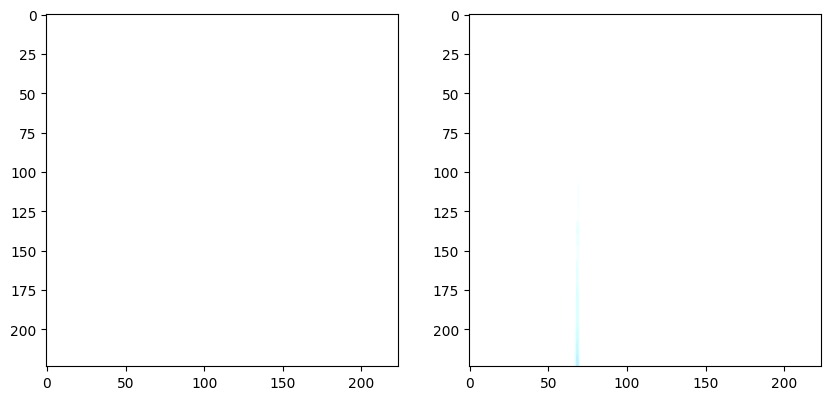

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


第二个就是你可以改变自己还款的一个频率
label: 0


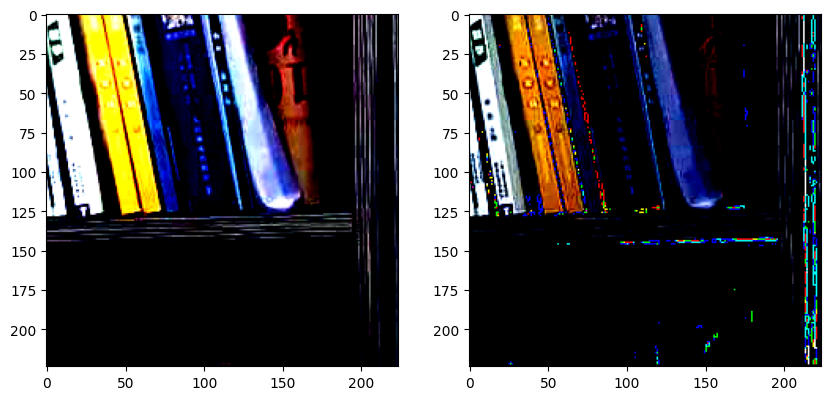

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


他的分530多分
label: 0


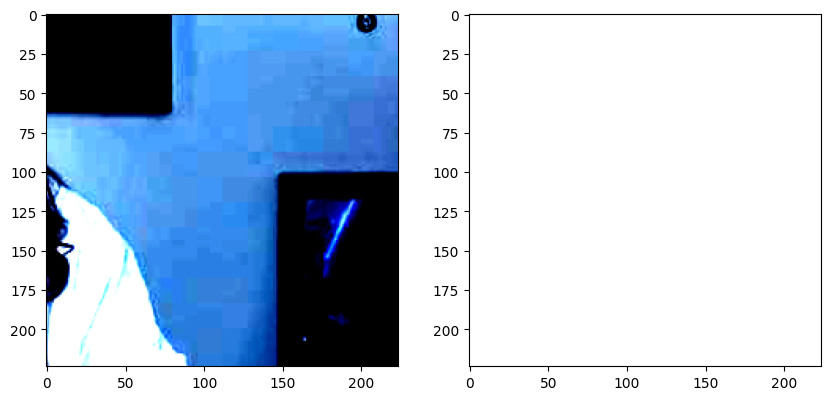

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


小色色的
label: 1


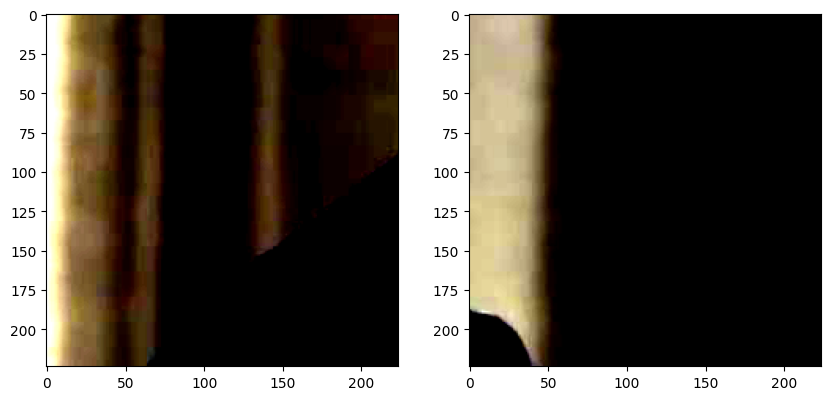

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


猛男的感觉出来了是不是
label: 1


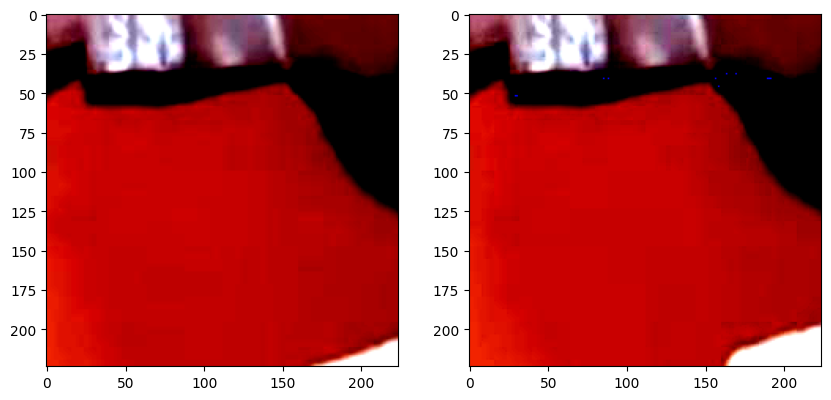

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


好像有点印象
label: 0


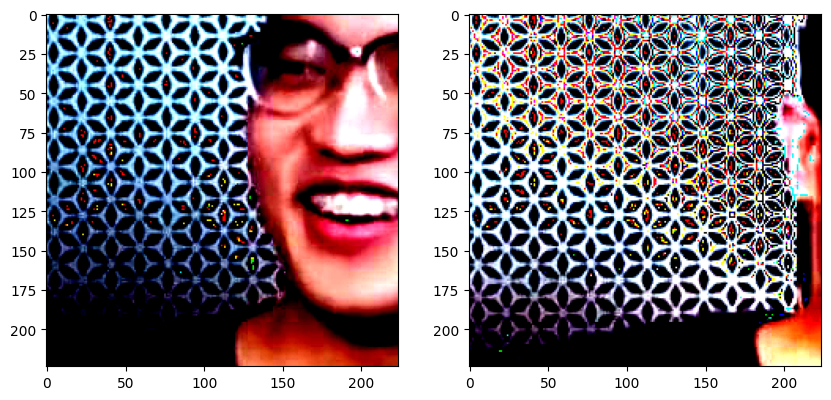

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


你是一个经济师
label: 1


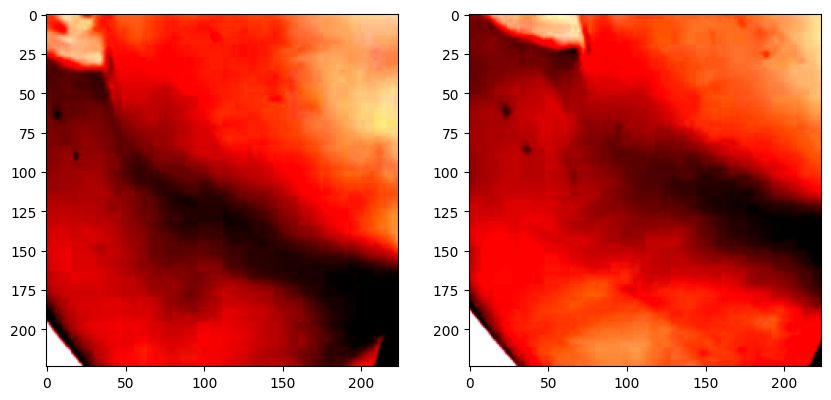

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


他们来煮那豆
label: 0


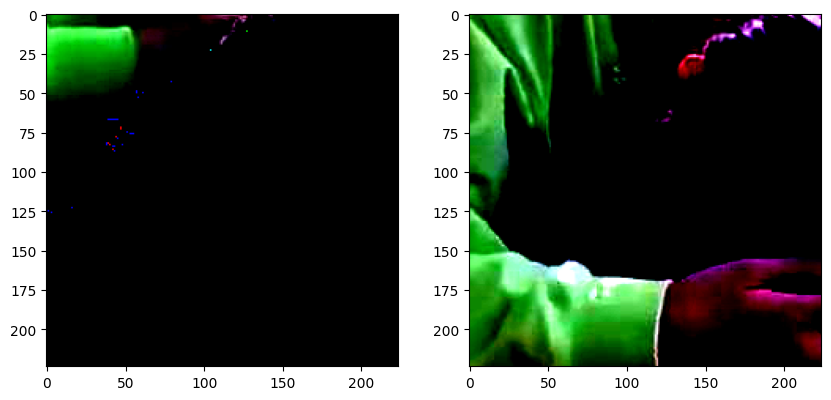

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


让本不多的头发雪上加霜
label: 1


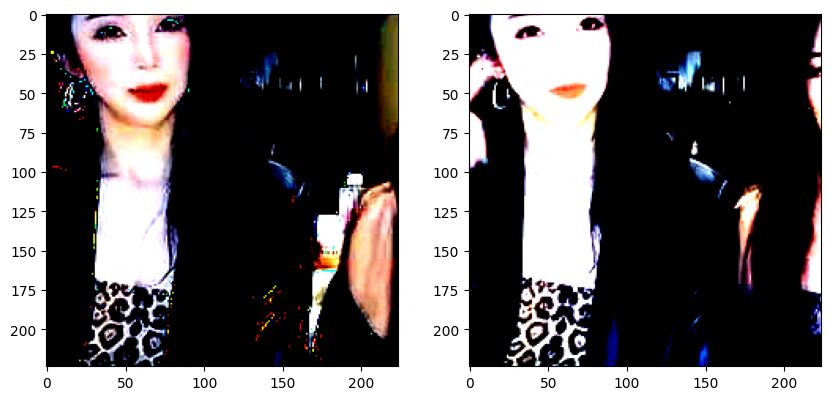

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Yes
label: 0


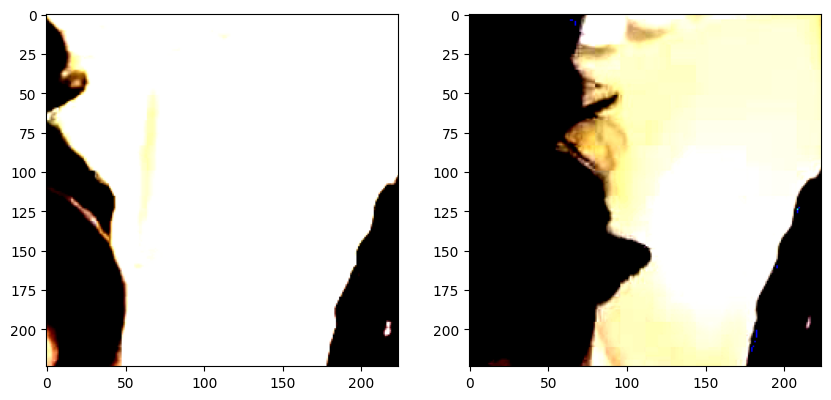

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


维持和谐的夫妻关系
label: 1


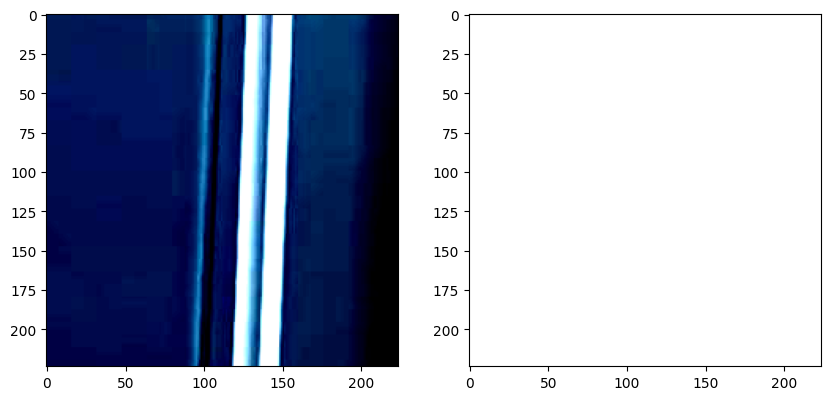

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 You need to be a good person.
label: 0


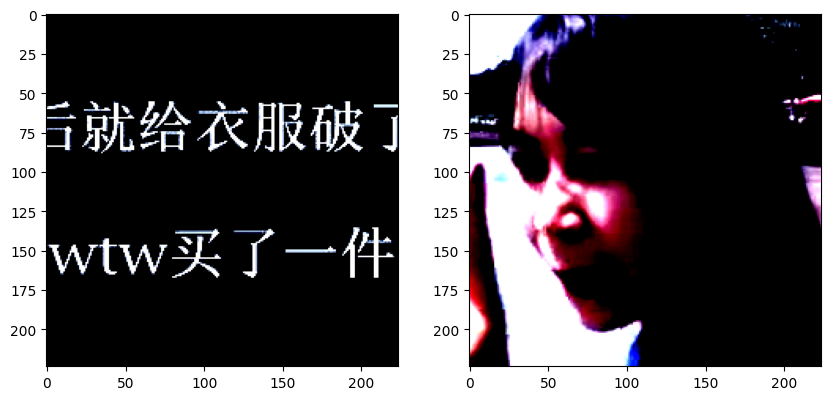

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


我们第一站八十光年
label: 0


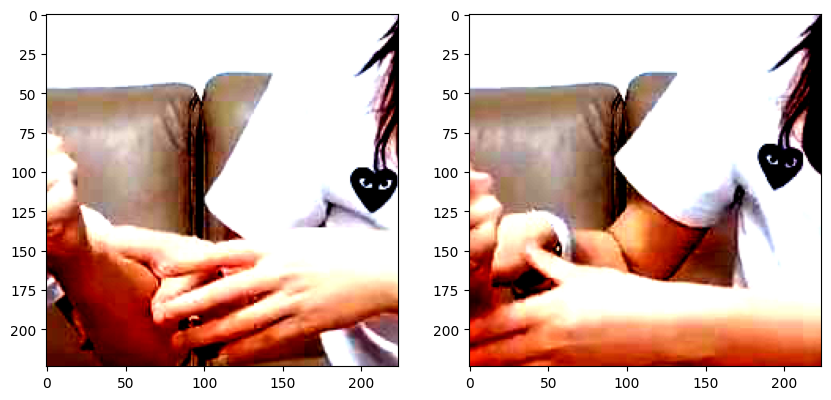

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


你把钱都拿来
label: 1


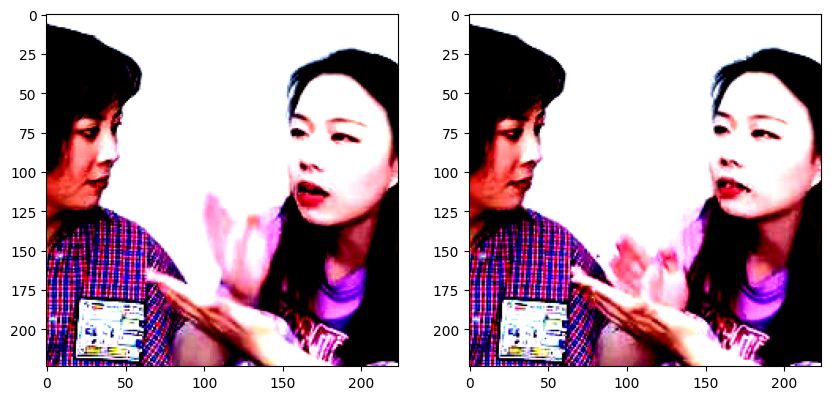

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


讓他們兩個自由嗎
label: 0


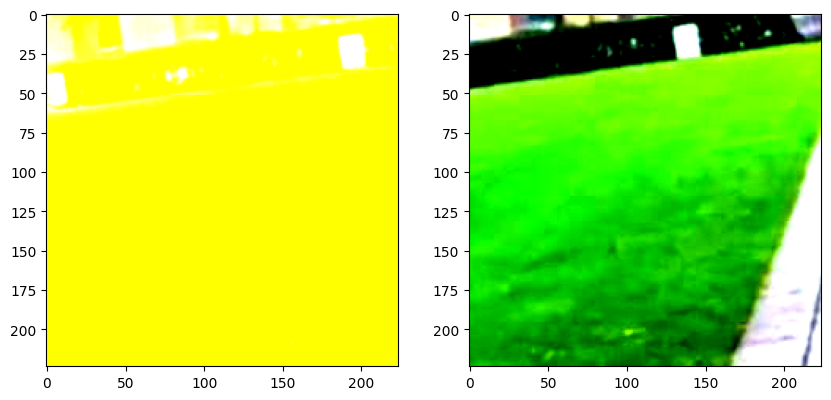

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


苹果
label: 0


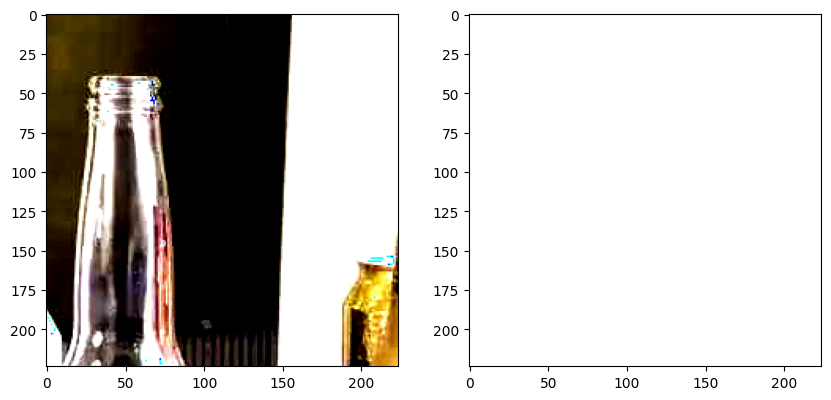

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


阿姨阿姨拉起头拉起头好吧
label: 1


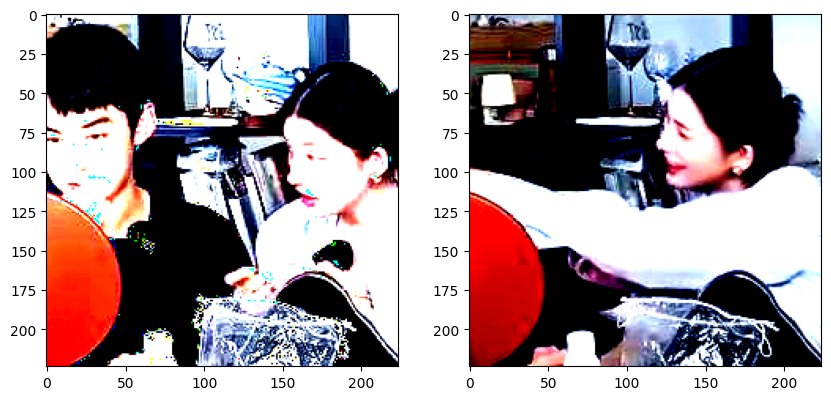

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


要卸的来玩
label: 0


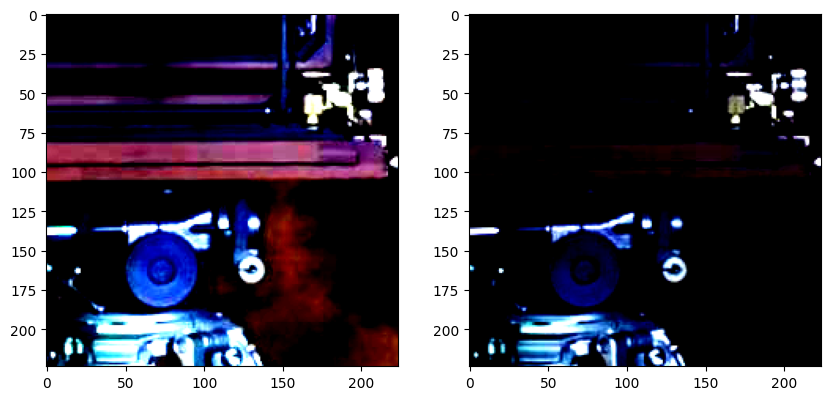

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


所以說我覺得非常有必要立一個flag
label: 1


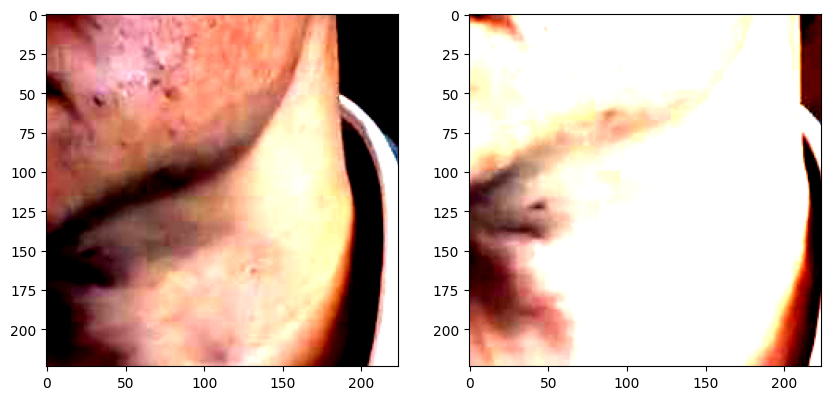

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


对涉及到这些政府的一些很多的规定
label: 0


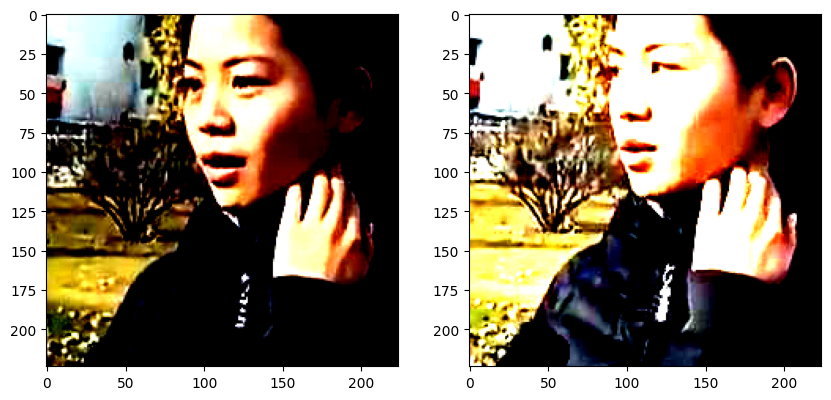

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


周日
label: 0


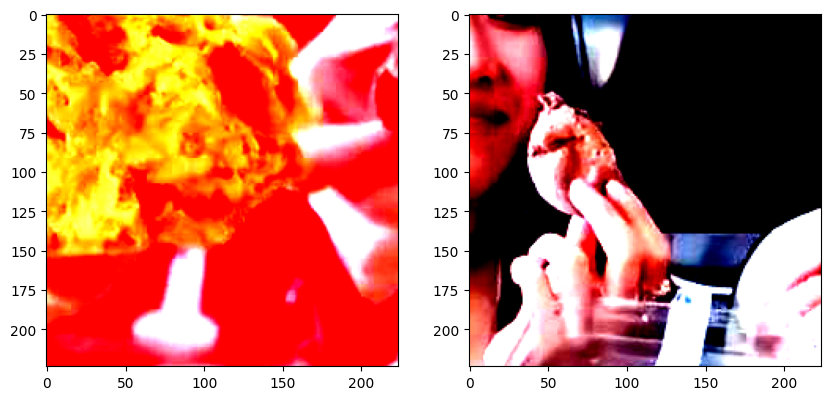

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


她吃巧克力我吃抹茶
label: 1


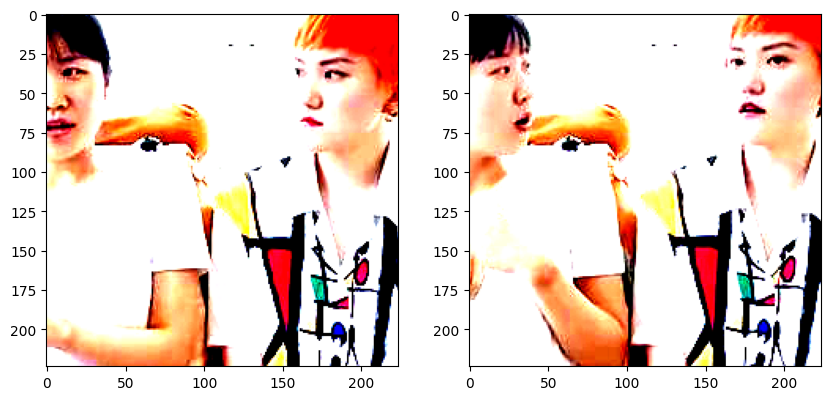

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


你可能就你的lifestyle并不比现在好多少
label: 0


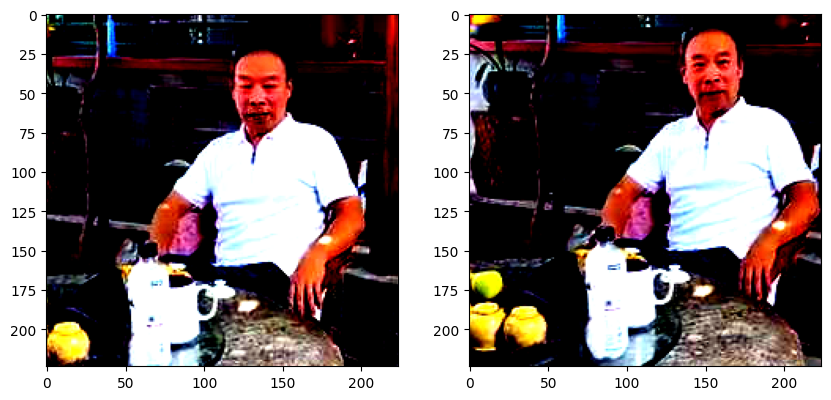

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


他脸还刮的下来
label: 1


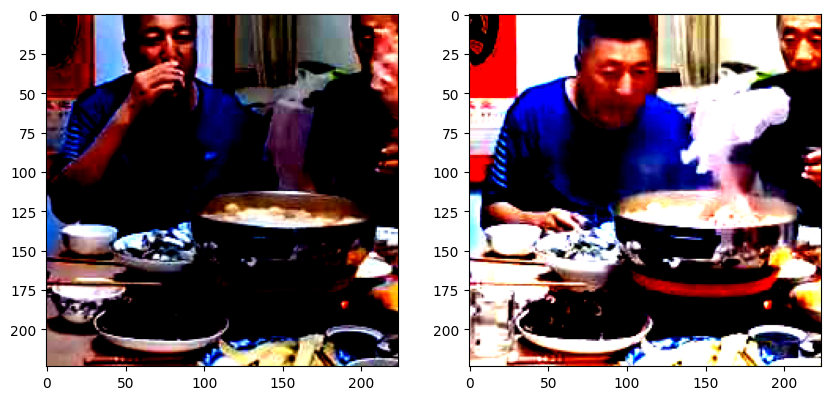

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


就不去上班是吧
label: 0


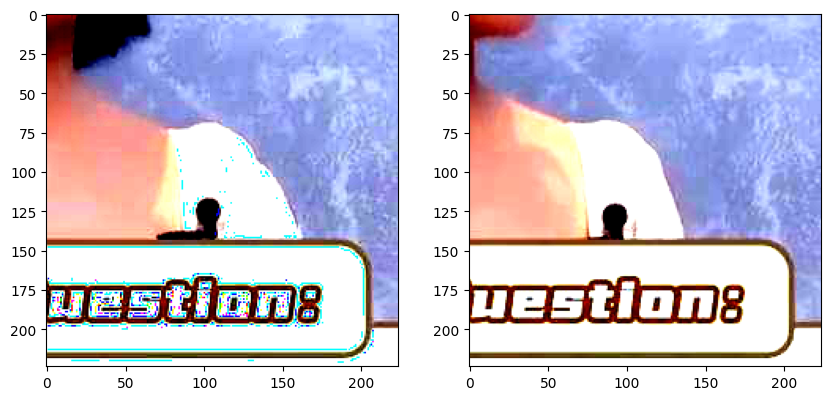

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


可以提高我们财商的一些书
label: 1


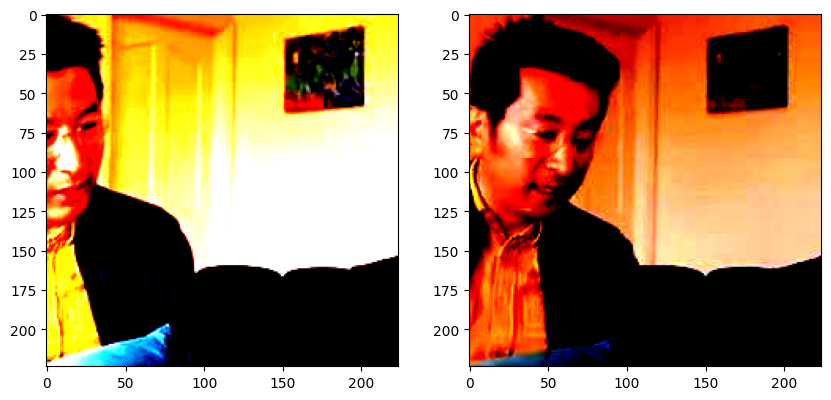

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


你說這個問題我有方案
label: 1


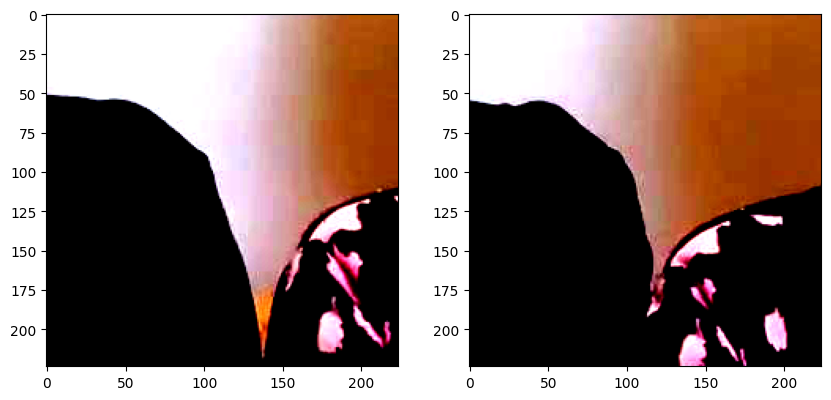

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


就因为我们在不断的追赶时尚
label: 1


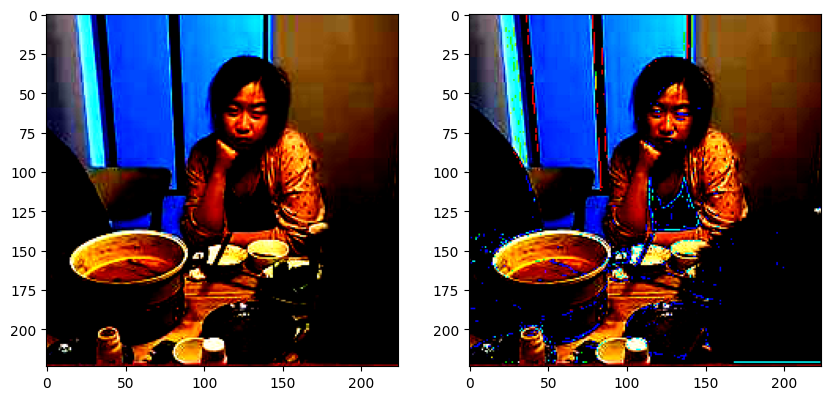

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


所以你要说我在意不在意
label: 0


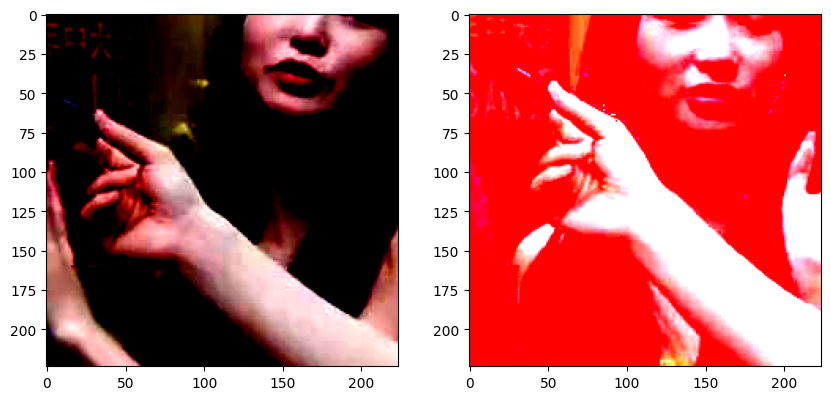

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


情侣之间
label: 1


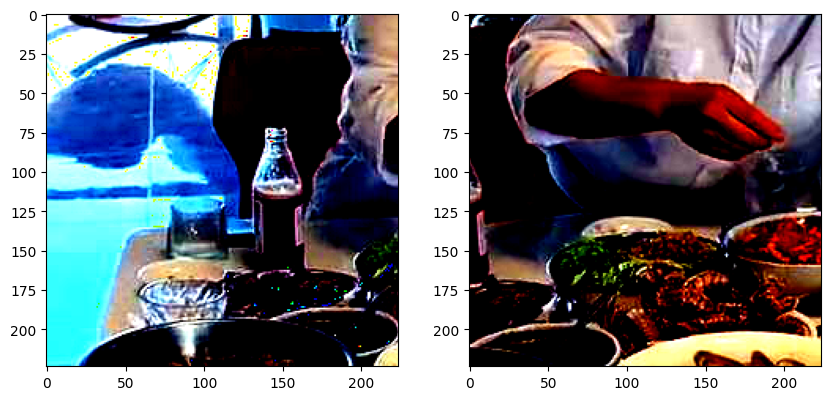

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


谁的生日都快乐
label: 0


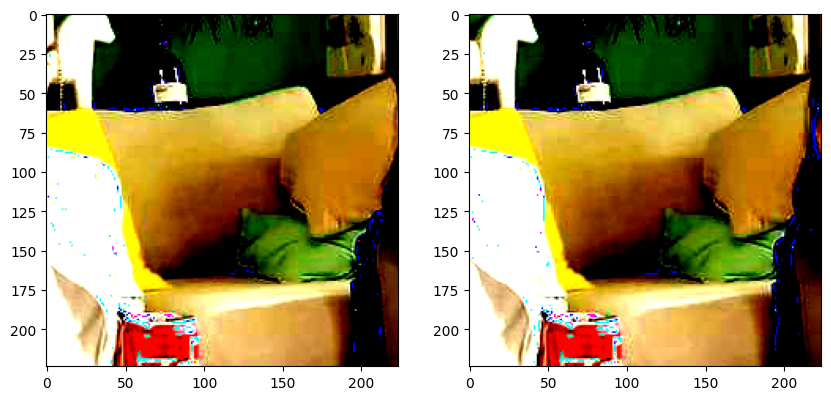

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


很多事情我根本就没有做过
label: 1


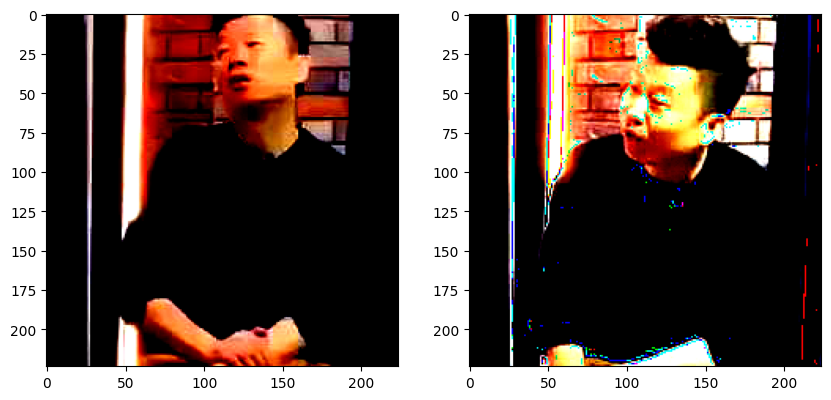

一套1000多万对吗
label: 1


In [9]:
for batch in test_data_loader:
    show_a_batch(batch)
    break

In [10]:
# run this chunk when training
# parameters
trained_cls_model_path = '/mnt/swordfish-pool2/kh3074/train_cls_head_first/trained_cls_head_model/model_tuned_epoch_44'
train_batch_size = 50
eval_batch_size = 512
num_epoch = 20
custom_lr = 0.00002

# load model
my_nvlr_model = NLVRModel(config=config)

# load pretrianed feature extractor
#my_nvlr_model.load_pretrained('data/cclm_4m_epoch_29.th', config,  ## need to match 3m or 4m
#                              load_nlvr_pretrain= False, is_eval=False) # load_nlvr_pretrain= False because current checkpoint is CCLM model

    
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
tokenizer.add_special_tokens({'bos_token': tokenizer.cls_token, 'eos_token': tokenizer.sep_token})

# training parameters 
world_size = utils.get_world_size()

arg_opt = utils.AttrDict(config['optimizer'])
arg_opt['lr'] = custom_lr
optimizer = create_optimizer(arg_opt, my_nvlr_model)
arg_sche = utils.AttrDict(config['schedular'])
arg_sche['step_per_epoch'] = math.ceil(len(train_dataset)/(train_batch_size*world_size))
lr_scheduler = create_scheduler(arg_sche, optimizer)
log = []
my_nvlr_model = nn.DataParallel(my_nvlr_model)
checkpoint_ldc = torch.load(trained_cls_model_path, map_location=device)
my_nvlr_model.load_state_dict(checkpoint_ldc) # load_nlvr_pretrain= False because current checkpoint is CCLM model
my_nvlr_model.to(device)

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### lr_mult,  2
### model has 'init_params',  6
### num_training_steps,  990
### num_warmup_steps,  2500


/home/kh3074/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


DataParallel(
  (module): NLVRModel(
    (vision_encoder): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0): BasicLayer(
          dim=128, input_resolution=(56, 56), depth=2
          (blocks): ModuleList(
            (0): SwinTransformerBlock(
              dim=128, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0, mlp_ratio=4.0
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                dim=128, window_size=(7, 7), num_heads=4
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): D

Start training!!


/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [0] [  0/141]  eta: 0:25:05  lr: 0.000000  loss: 0.6796  time: 10.6749  data: 6.2297  max mem: 17829
Train Epoch: [0] [ 20/141]  eta: 0:03:26  lr: 0.000000  loss: 0.7109  time: 1.2575  data: 0.3808  max mem: 24000
Train Epoch: [0] [ 40/141]  eta: 0:02:35  lr: 0.000000  loss: 0.6630  time: 1.3686  data: 0.4723  max mem: 27325
Train Epoch: [0] [ 60/141]  eta: 0:02:02  lr: 0.000000  loss: 0.6111  time: 1.4691  data: 0.2727  max mem: 27335
Train Epoch: [0] [ 80/141]  eta: 0:01:23  lr: 0.000001  loss: 0.6857  time: 0.8986  data: 0.0140  max mem: 27335
Train Epoch: [0] [100/141]  eta: 0:00:54  lr: 0.000001  loss: 0.6473  time: 1.2167  data: 0.3332  max mem: 27335
Train Epoch: [0] [120/141]  eta: 0:00:28  lr: 0.000001  loss: 0.6347  time: 1.3305  data: 0.4443  max mem: 27335
Train Epoch: [0] [140/141]  eta: 0:00:01  lr: 0.000001  loss: 0.5867  time: 1.2696  data: 0.2150  max mem: 27335
Train Epoch: [0] Total time: 0:03:06 (1.3255 s / it)
start eval on train dataset --------------

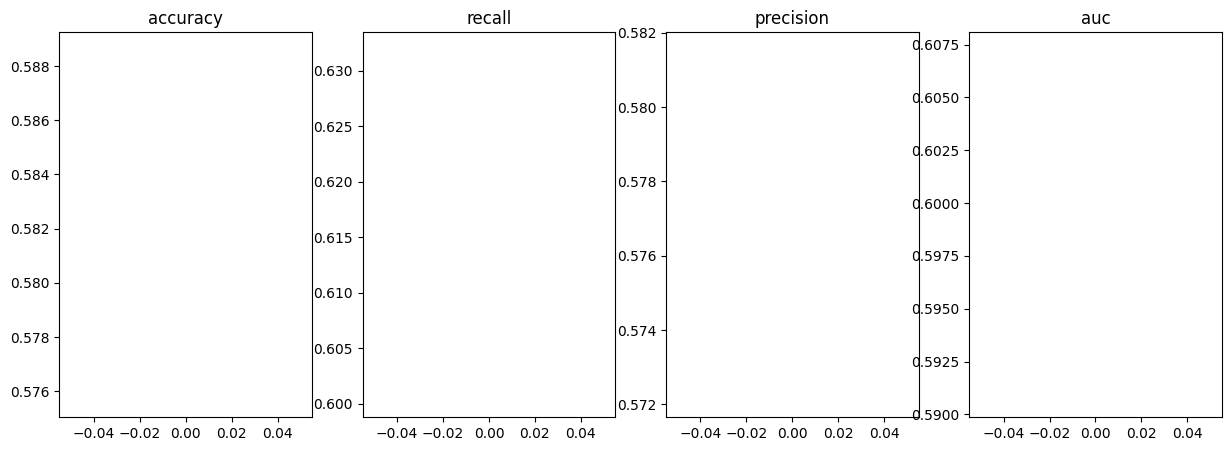

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [1] [  0/141]  eta: 0:23:20  lr: 0.000001  loss: 0.6780  time: 9.9361  data: 8.9087  max mem: 27335
Train Epoch: [1] [ 20/141]  eta: 0:04:01  lr: 0.000001  loss: 0.6820  time: 1.5969  data: 0.7002  max mem: 27335
Train Epoch: [1] [ 40/141]  eta: 0:03:19  lr: 0.000001  loss: 0.6670  time: 1.9574  data: 0.7646  max mem: 27335
Train Epoch: [1] [ 60/141]  eta: 0:02:23  lr: 0.000002  loss: 0.6589  time: 1.3522  data: 0.4312  max mem: 27385
Train Epoch: [1] [ 80/141]  eta: 0:01:44  lr: 0.000002  loss: 0.5854  time: 1.5563  data: 0.6573  max mem: 27385
Train Epoch: [1] [100/141]  eta: 0:01:09  lr: 0.000002  loss: 0.6722  time: 1.6564  data: 0.7472  max mem: 27394
Train Epoch: [1] [120/141]  eta: 0:00:36  lr: 0.000002  loss: 0.6462  time: 1.8268  data: 0.7237  max mem: 27396
Train Epoch: [1] [140/141]  eta: 0:00:01  lr: 0.000002  loss: 0.7125  time: 1.1087  data: 0.2192  max mem: 27396
Train Epoch: [1] Total time: 0:03:51 (1.6386 s / it)
start eval on train dataset ---------------

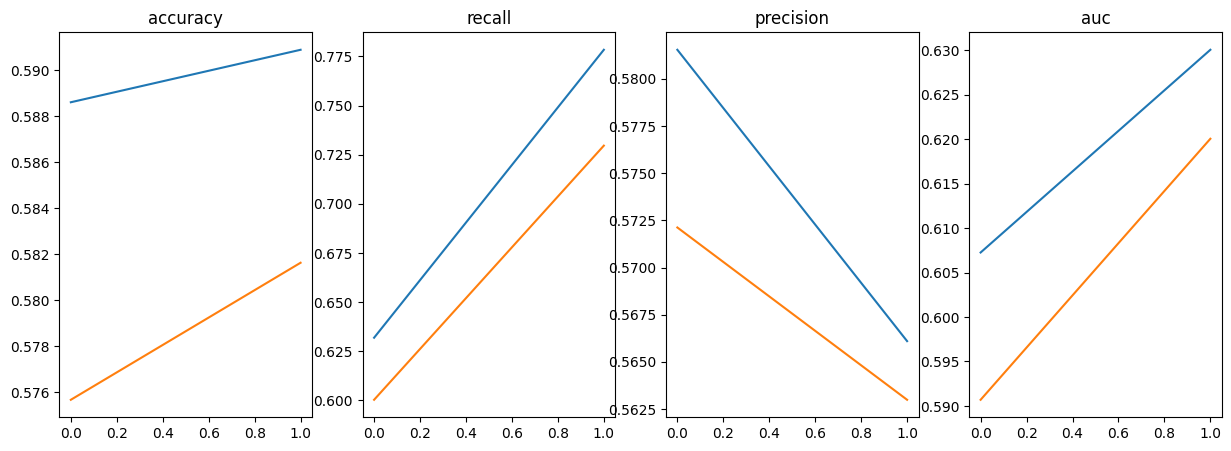

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [2] [  0/141]  eta: 0:19:30  lr: 0.000002  loss: 0.7066  time: 8.3011  data: 7.2486  max mem: 27396
Train Epoch: [2] [ 20/141]  eta: 0:03:43  lr: 0.000002  loss: 0.6798  time: 1.5281  data: 0.6184  max mem: 27396
Train Epoch: [2] [ 40/141]  eta: 0:02:39  lr: 0.000003  loss: 0.7012  time: 1.2895  data: 0.1392  max mem: 27396
Train Epoch: [2] [ 60/141]  eta: 0:02:04  lr: 0.000003  loss: 0.6576  time: 1.4691  data: 0.5555  max mem: 27396
Train Epoch: [2] [ 80/141]  eta: 0:01:32  lr: 0.000003  loss: 0.6482  time: 1.4534  data: 0.5163  max mem: 28887
Train Epoch: [2] [100/141]  eta: 0:01:00  lr: 0.000003  loss: 0.6381  time: 1.3035  data: 0.3996  max mem: 28887
Train Epoch: [2] [120/141]  eta: 0:00:30  lr: 0.000003  loss: 0.6179  time: 1.4156  data: 0.3396  max mem: 28887
Train Epoch: [2] [140/141]  eta: 0:00:01  lr: 0.000003  loss: 0.5276  time: 1.3784  data: 0.5092  max mem: 28887
Train Epoch: [2] Total time: 0:03:25 (1.4543 s / it)
start eval on train dataset ---------------

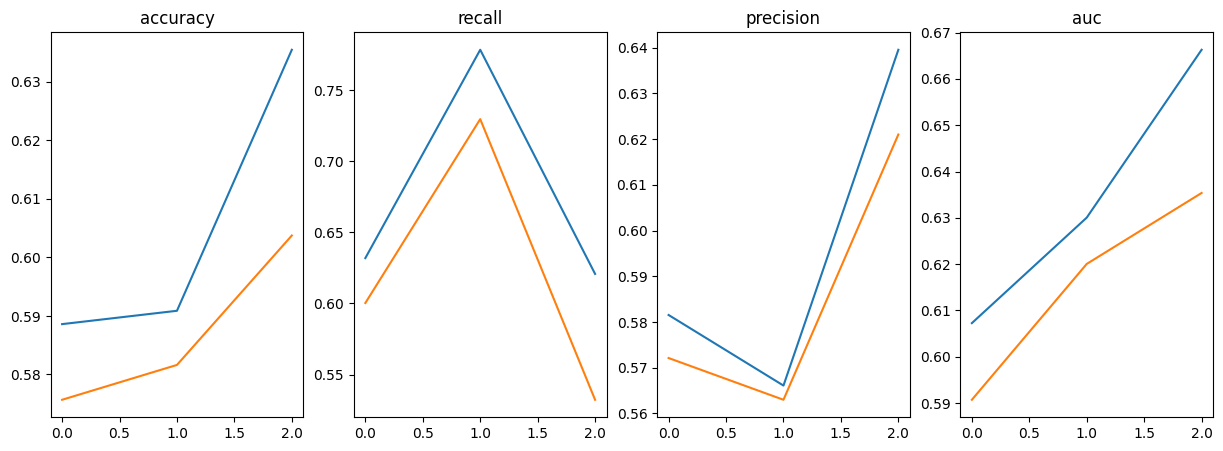

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [3] [  0/141]  eta: 0:18:10  lr: 0.000003  loss: 0.7076  time: 7.7333  data: 6.7124  max mem: 28887
Train Epoch: [3] [ 20/141]  eta: 0:03:26  lr: 0.000004  loss: 0.5948  time: 1.4072  data: 0.2655  max mem: 28887
Train Epoch: [3] [ 40/141]  eta: 0:02:52  lr: 0.000004  loss: 0.6096  time: 1.7040  data: 0.8132  max mem: 28887
Train Epoch: [3] [ 60/141]  eta: 0:02:16  lr: 0.000004  loss: 0.6870  time: 1.6551  data: 0.7419  max mem: 28887
Train Epoch: [3] [ 80/141]  eta: 0:01:37  lr: 0.000004  loss: 0.6231  time: 1.3356  data: 0.4460  max mem: 28887
Train Epoch: [3] [100/141]  eta: 0:01:04  lr: 0.000004  loss: 0.5972  time: 1.4173  data: 0.3348  max mem: 28887
Train Epoch: [3] [120/141]  eta: 0:00:32  lr: 0.000004  loss: 0.6150  time: 1.4592  data: 0.5336  max mem: 28887
Train Epoch: [3] [140/141]  eta: 0:00:01  lr: 0.000005  loss: 0.6274  time: 1.4206  data: 0.5392  max mem: 28887
Train Epoch: [3] Total time: 0:03:35 (1.5300 s / it)
start eval on train dataset ---------------

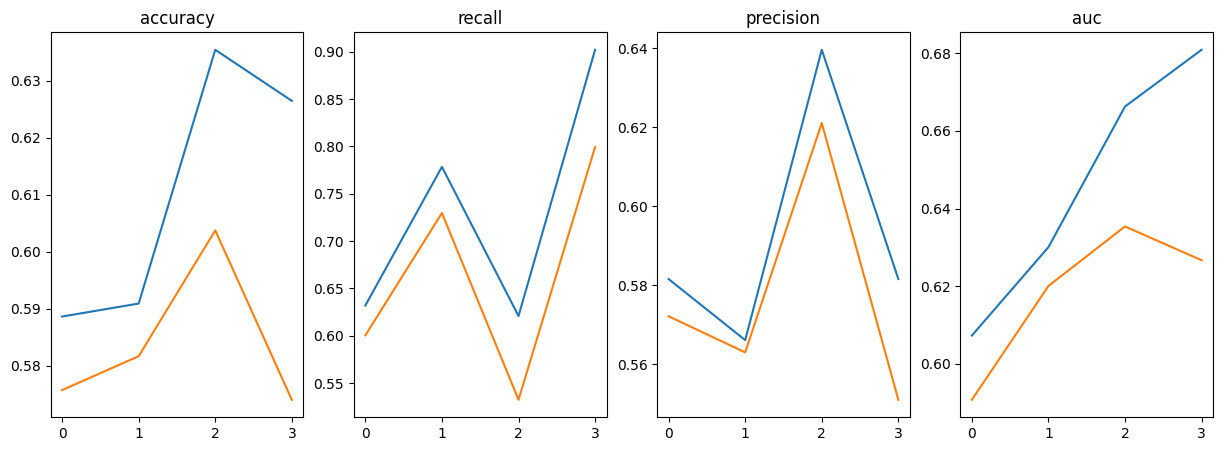

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [4] [  0/141]  eta: 0:17:06  lr: 0.000005  loss: 0.6402  time: 7.2782  data: 6.2623  max mem: 28887
Train Epoch: [4] [ 20/141]  eta: 0:03:21  lr: 0.000005  loss: 0.6332  time: 1.3809  data: 0.5040  max mem: 28887
Train Epoch: [4] [ 40/141]  eta: 0:02:30  lr: 0.000005  loss: 0.5611  time: 1.3137  data: 0.4099  max mem: 28887
Train Epoch: [4] [ 60/141]  eta: 0:02:04  lr: 0.000005  loss: 0.5681  time: 1.6376  data: 0.7389  max mem: 28887
Train Epoch: [4] [ 80/141]  eta: 0:01:34  lr: 0.000005  loss: 0.6179  time: 1.5923  data: 0.3655  max mem: 28887
Train Epoch: [4] [100/141]  eta: 0:01:02  lr: 0.000005  loss: 0.6051  time: 1.4685  data: 0.5554  max mem: 28887
Train Epoch: [4] [120/141]  eta: 0:00:31  lr: 0.000005  loss: 0.6344  time: 1.4523  data: 0.5270  max mem: 28887
Train Epoch: [4] [140/141]  eta: 0:00:01  lr: 0.000006  loss: 0.4798  time: 1.4033  data: 0.5290  max mem: 28887
Train Epoch: [4] Total time: 0:03:32 (1.5054 s / it)
start eval on train dataset ---------------

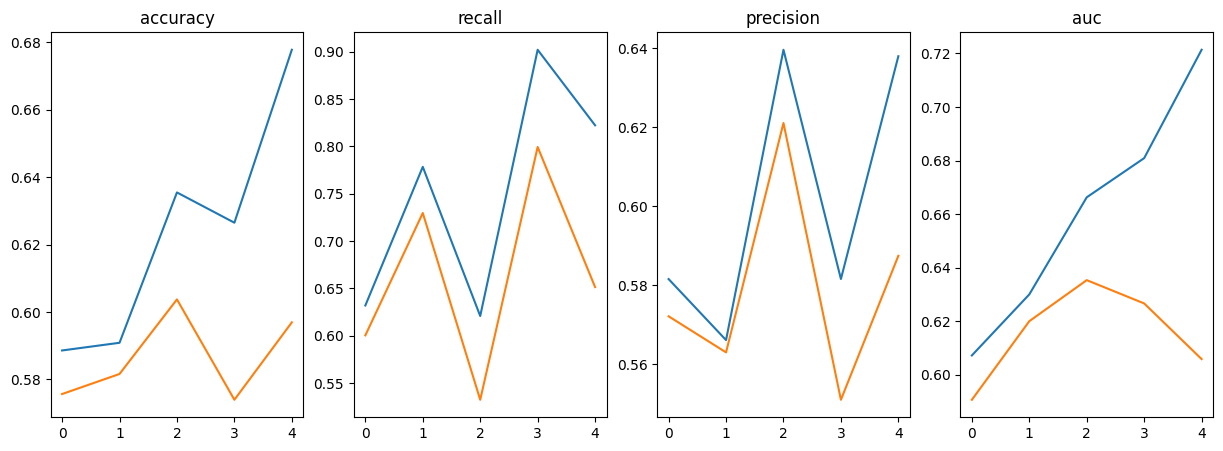

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [5] [  0/141]  eta: 0:19:06  lr: 0.000006  loss: 0.5642  time: 8.1322  data: 7.0750  max mem: 28887
Train Epoch: [5] [ 20/141]  eta: 0:04:13  lr: 0.000006  loss: 0.5743  time: 1.7909  data: 0.8682  max mem: 28887
Train Epoch: [5] [ 40/141]  eta: 0:03:16  lr: 0.000006  loss: 0.5885  time: 1.7931  data: 0.8784  max mem: 28887
Train Epoch: [5] [ 60/141]  eta: 0:02:31  lr: 0.000006  loss: 0.6134  time: 1.7120  data: 0.5389  max mem: 28887
Train Epoch: [5] [ 80/141]  eta: 0:01:52  lr: 0.000006  loss: 0.5837  time: 1.7589  data: 0.8392  max mem: 28887
Train Epoch: [5] [100/141]  eta: 0:01:15  lr: 0.000006  loss: 0.5152  time: 1.8412  data: 0.9220  max mem: 28887
Train Epoch: [5] [120/141]  eta: 0:00:40  lr: 0.000007  loss: 0.5407  time: 2.4039  data: 1.5086  max mem: 28887
Train Epoch: [5] [140/141]  eta: 0:00:02  lr: 0.000007  loss: 0.6350  time: 2.5291  data: 1.4583  max mem: 28887
Train Epoch: [5] Total time: 0:04:44 (2.0193 s / it)
start eval on train dataset ---------------

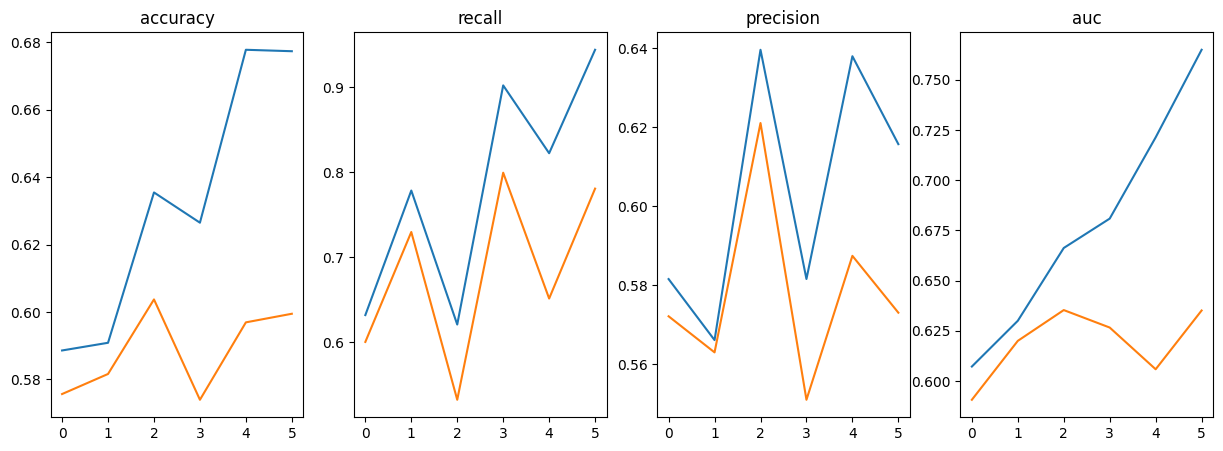

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [6] [  0/141]  eta: 0:35:12  lr: 0.000007  loss: 0.7206  time: 14.9857  data: 13.8903  max mem: 28887
Train Epoch: [6] [ 20/141]  eta: 0:09:19  lr: 0.000007  loss: 0.4802  time: 4.1027  data: 3.1787  max mem: 28887
Train Epoch: [6] [ 40/141]  eta: 0:07:08  lr: 0.000007  loss: 0.4029  time: 3.8484  data: 2.7098  max mem: 28887
Train Epoch: [6] [ 60/141]  eta: 0:05:24  lr: 0.000007  loss: 0.4488  time: 3.5058  data: 2.6054  max mem: 28887
Train Epoch: [6] [ 80/141]  eta: 0:04:01  lr: 0.000007  loss: 0.4658  time: 3.8500  data: 2.9441  max mem: 28887
Train Epoch: [6] [100/141]  eta: 0:02:40  lr: 0.000008  loss: 0.5006  time: 3.7313  data: 2.8204  max mem: 28887
Train Epoch: [6] [120/141]  eta: 0:01:21  lr: 0.000008  loss: 0.4293  time: 3.5779  data: 2.4759  max mem: 28887
Train Epoch: [6] [140/141]  eta: 0:00:03  lr: 0.000008  loss: 0.6485  time: 3.2526  data: 2.3683  max mem: 28887
Train Epoch: [6] Total time: 0:08:52 (3.7757 s / it)
start eval on train dataset -------------

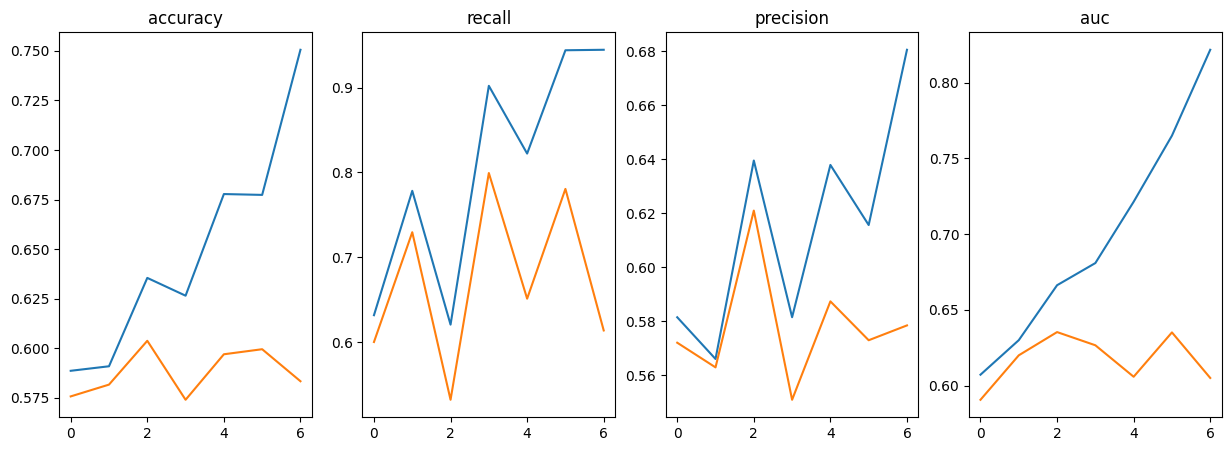

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [7] [  0/141]  eta: 0:41:06  lr: 0.000008  loss: 0.5410  time: 17.4958  data: 16.4371  max mem: 28887
Train Epoch: [7] [ 20/141]  eta: 0:09:05  lr: 0.000008  loss: 0.4510  time: 3.8574  data: 2.6951  max mem: 28887
Train Epoch: [7] [ 40/141]  eta: 0:06:39  lr: 0.000008  loss: 0.3983  time: 3.3741  data: 2.4424  max mem: 28887
Train Epoch: [7] [ 60/141]  eta: 0:05:06  lr: 0.000008  loss: 0.4620  time: 3.4520  data: 2.5403  max mem: 28887
Train Epoch: [7] [ 80/141]  eta: 0:03:39  lr: 0.000009  loss: 0.6615  time: 3.0056  data: 2.1060  max mem: 28887
Train Epoch: [7] [100/141]  eta: 0:02:24  lr: 0.000009  loss: 0.5052  time: 3.2328  data: 2.1500  max mem: 28887
Train Epoch: [7] [120/141]  eta: 0:01:12  lr: 0.000009  loss: 0.3809  time: 2.9892  data: 2.0959  max mem: 28887
Train Epoch: [7] [140/141]  eta: 0:00:03  lr: 0.000009  loss: 0.4414  time: 3.0836  data: 2.2033  max mem: 28887
Train Epoch: [7] Total time: 0:07:57 (3.3858 s / it)
start eval on train dataset -------------

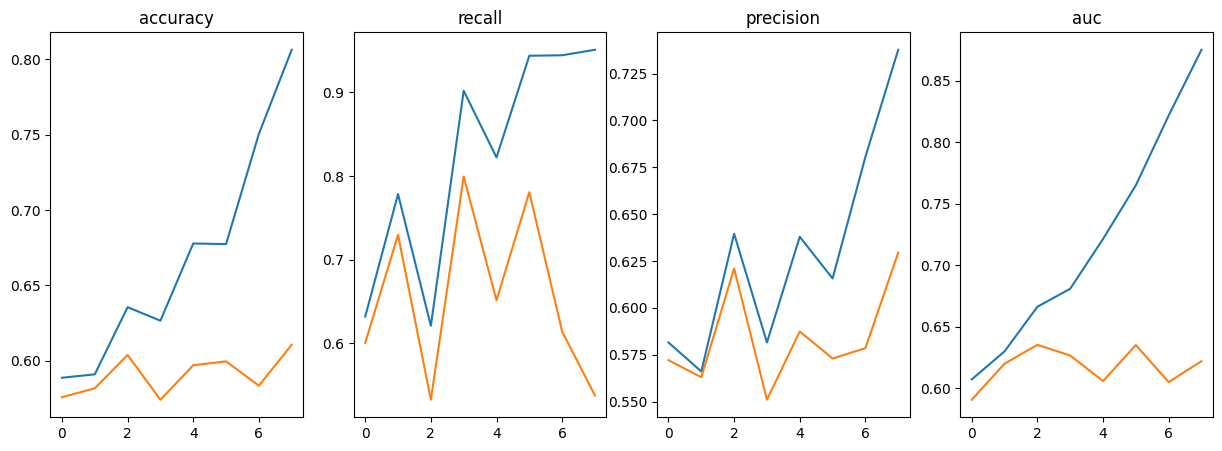

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [8] [  0/141]  eta: 0:31:11  lr: 0.000009  loss: 0.3821  time: 13.2755  data: 11.9513  max mem: 28887
Train Epoch: [8] [ 20/141]  eta: 0:04:30  lr: 0.000009  loss: 0.3855  time: 1.6870  data: 0.7710  max mem: 28887
Train Epoch: [8] [ 40/141]  eta: 0:03:32  lr: 0.000009  loss: 0.5180  time: 1.9645  data: 1.0688  max mem: 28887
Train Epoch: [8] [ 60/141]  eta: 0:02:50  lr: 0.000010  loss: 0.4933  time: 2.0876  data: 1.1772  max mem: 28887
Train Epoch: [8] [ 80/141]  eta: 0:02:06  lr: 0.000010  loss: 0.3260  time: 1.9900  data: 0.8282  max mem: 28887
Train Epoch: [8] [100/141]  eta: 0:01:23  lr: 0.000010  loss: 0.4148  time: 1.9375  data: 1.0187  max mem: 28887
Train Epoch: [8] [120/141]  eta: 0:00:42  lr: 0.000010  loss: 0.3312  time: 1.8187  data: 0.9192  max mem: 28887
Train Epoch: [8] [140/141]  eta: 0:00:01  lr: 0.000010  loss: 0.4353  time: 1.6257  data: 0.7408  max mem: 28887
Train Epoch: [8] Total time: 0:04:35 (1.9539 s / it)
start eval on train dataset -------------

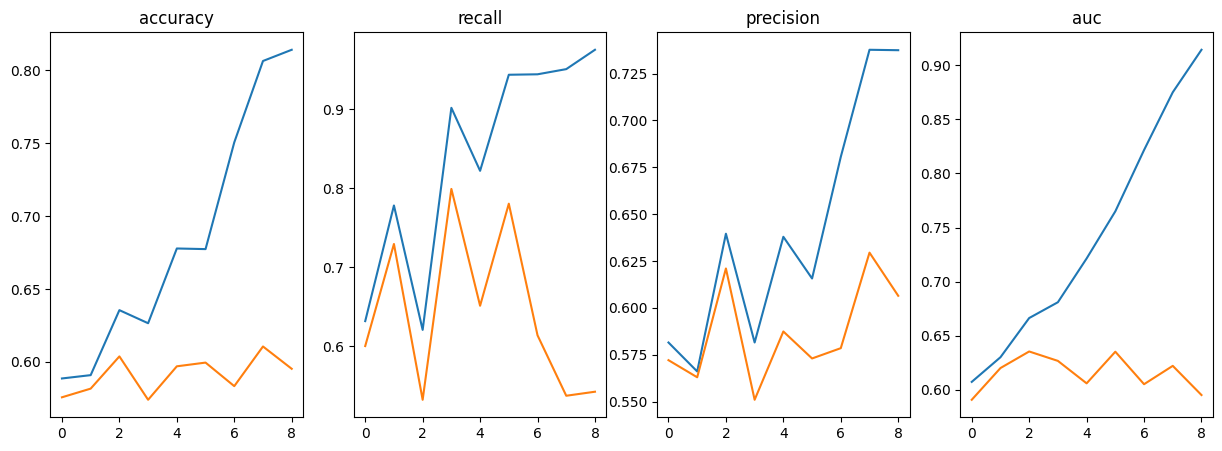

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [9] [  0/141]  eta: 0:19:44  lr: 0.000010  loss: 0.3855  time: 8.4022  data: 7.3464  max mem: 28887
Train Epoch: [9] [ 20/141]  eta: 0:03:27  lr: 0.000010  loss: 0.3378  time: 1.3774  data: 0.4591  max mem: 28887
Train Epoch: [9] [ 40/141]  eta: 0:02:38  lr: 0.000010  loss: 0.3408  time: 1.4100  data: 0.5189  max mem: 28887
Train Epoch: [9] [ 60/141]  eta: 0:02:05  lr: 0.000011  loss: 0.4290  time: 1.5079  data: 0.3429  max mem: 28887
Train Epoch: [9] [ 80/141]  eta: 0:01:29  lr: 0.000011  loss: 0.2787  time: 1.2463  data: 0.3362  max mem: 28887
Train Epoch: [9] [100/141]  eta: 0:00:59  lr: 0.000011  loss: 0.3006  time: 1.4154  data: 0.5006  max mem: 28887
Train Epoch: [9] [120/141]  eta: 0:00:29  lr: 0.000011  loss: 0.3913  time: 1.1848  data: 0.2745  max mem: 28887
Train Epoch: [9] [140/141]  eta: 0:00:01  lr: 0.000011  loss: 0.3204  time: 1.3587  data: 0.2723  max mem: 28887
Train Epoch: [9] Total time: 0:03:18 (1.4072 s / it)
start eval on train dataset ---------------

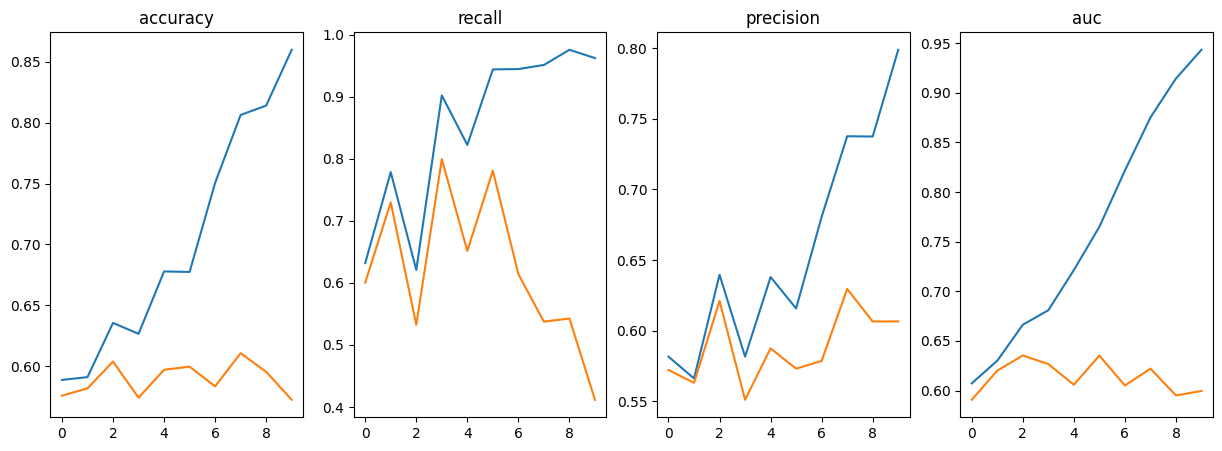

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [10] [  0/141]  eta: 0:17:44  lr: 0.000011  loss: 0.3113  time: 7.5470  data: 6.4843  max mem: 28887
Train Epoch: [10] [ 20/141]  eta: 0:03:17  lr: 0.000011  loss: 0.3815  time: 1.3350  data: 0.4351  max mem: 28887
Train Epoch: [10] [ 40/141]  eta: 0:02:42  lr: 0.000012  loss: 0.2629  time: 1.5759  data: 0.4126  max mem: 28887
Train Epoch: [10] [ 60/141]  eta: 0:01:55  lr: 0.000012  loss: 0.3109  time: 1.0723  data: 0.1654  max mem: 28887
Train Epoch: [10] [ 80/141]  eta: 0:01:26  lr: 0.000012  loss: 0.3623  time: 1.3503  data: 0.4431  max mem: 28887
Train Epoch: [10] [100/141]  eta: 0:00:57  lr: 0.000012  loss: 0.2969  time: 1.3284  data: 0.4244  max mem: 28887
Train Epoch: [10] [120/141]  eta: 0:00:29  lr: 0.000012  loss: 0.2776  time: 1.5150  data: 0.4011  max mem: 28887
Train Epoch: [10] [140/141]  eta: 0:00:01  lr: 0.000012  loss: 0.1576  time: 1.0950  data: 0.2149  max mem: 28887
Train Epoch: [10] Total time: 0:03:12 (1.3687 s / it)
start eval on train dataset ------

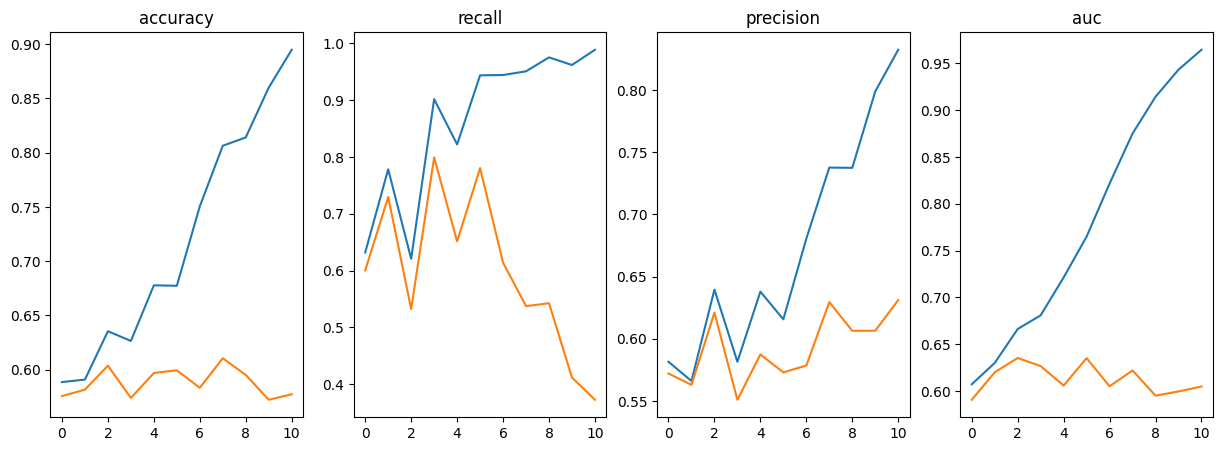

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [11] [  0/141]  eta: 0:17:51  lr: 0.000012  loss: 0.2499  time: 7.5984  data: 6.5446  max mem: 28887
Train Epoch: [11] [ 20/141]  eta: 0:03:35  lr: 0.000013  loss: 0.3228  time: 1.4860  data: 0.5845  max mem: 28887
Train Epoch: [11] [ 40/141]  eta: 0:02:42  lr: 0.000013  loss: 0.2542  time: 1.4388  data: 0.1459  max mem: 28887
Train Epoch: [11] [ 60/141]  eta: 0:02:04  lr: 0.000013  loss: 0.2175  time: 1.3944  data: 0.4947  max mem: 28887
Train Epoch: [11] [ 80/141]  eta: 0:01:30  lr: 0.000013  loss: 0.3014  time: 1.3125  data: 0.3892  max mem: 28887
Train Epoch: [11] [100/141]  eta: 0:00:58  lr: 0.000013  loss: 0.1913  time: 1.1717  data: 0.2723  max mem: 28887
Train Epoch: [11] [120/141]  eta: 0:00:29  lr: 0.000013  loss: 0.1759  time: 1.3305  data: 0.1289  max mem: 28887
Train Epoch: [11] [140/141]  eta: 0:00:01  lr: 0.000014  loss: 0.1575  time: 1.1934  data: 0.2914  max mem: 28887
Train Epoch: [11] Total time: 0:03:14 (1.3770 s / it)
start eval on train dataset ------

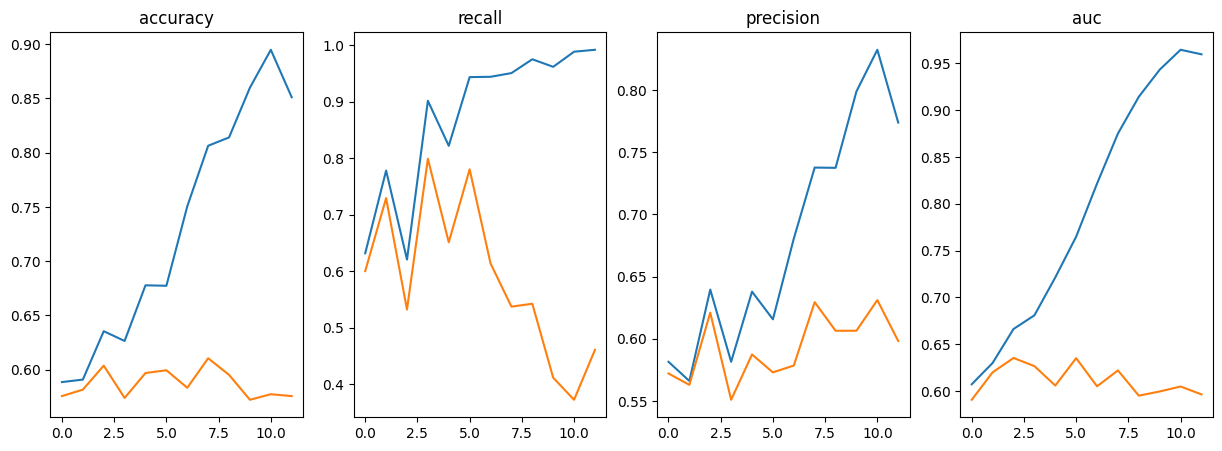

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [12] [  0/141]  eta: 0:18:38  lr: 0.000014  loss: 0.2181  time: 7.9300  data: 6.8282  max mem: 28887
Train Epoch: [12] [ 20/141]  eta: 0:03:19  lr: 0.000014  loss: 0.1883  time: 1.3379  data: 0.1799  max mem: 28887
Train Epoch: [12] [ 40/141]  eta: 0:02:32  lr: 0.000014  loss: 0.1704  time: 1.3613  data: 0.4415  max mem: 28887
Train Epoch: [12] [ 60/141]  eta: 0:01:56  lr: 0.000014  loss: 0.2021  time: 1.2777  data: 0.3829  max mem: 28887
Train Epoch: [12] [ 80/141]  eta: 0:01:27  lr: 0.000014  loss: 0.3094  time: 1.4272  data: 0.5272  max mem: 28887
Train Epoch: [12] [100/141]  eta: 0:00:58  lr: 0.000014  loss: 0.2169  time: 1.3707  data: 0.2615  max mem: 28887
Train Epoch: [12] [120/141]  eta: 0:00:30  lr: 0.000015  loss: 0.3639  time: 1.4963  data: 0.5947  max mem: 28887
Train Epoch: [12] [140/141]  eta: 0:00:01  lr: 0.000015  loss: 0.1753  time: 1.3255  data: 0.4357  max mem: 28887
Train Epoch: [12] Total time: 0:03:19 (1.4175 s / it)
start eval on train dataset ------

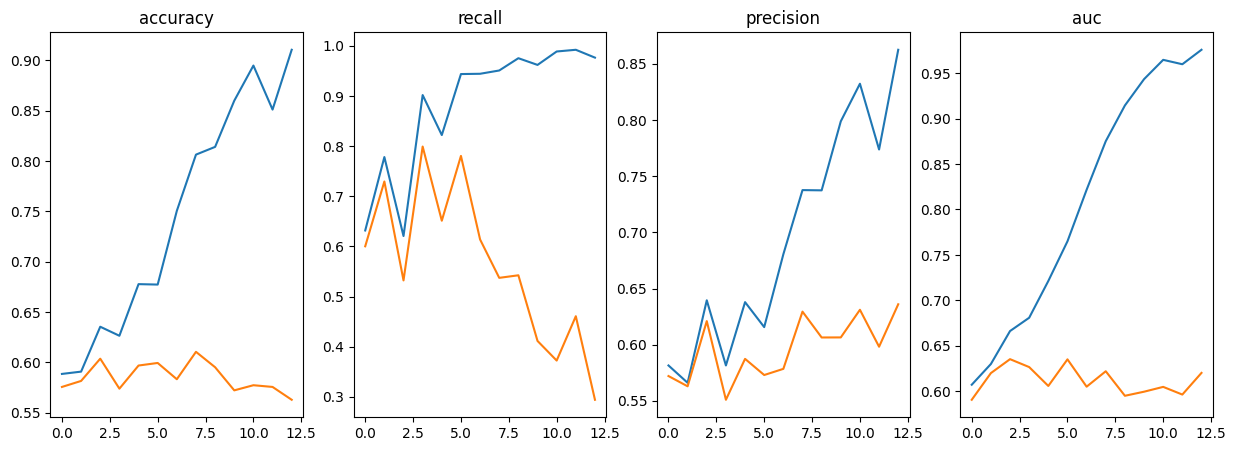

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [13] [  0/141]  eta: 0:20:15  lr: 0.000015  loss: 0.2040  time: 8.6225  data: 7.6227  max mem: 28887
Train Epoch: [13] [ 20/141]  eta: 0:03:20  lr: 0.000015  loss: 0.1954  time: 1.3081  data: 0.4033  max mem: 28887
Train Epoch: [13] [ 40/141]  eta: 0:02:31  lr: 0.000015  loss: 0.2475  time: 1.3351  data: 0.4442  max mem: 28887
Train Epoch: [13] [ 60/141]  eta: 0:01:59  lr: 0.000015  loss: 0.2349  time: 1.4127  data: 0.5241  max mem: 28887
Train Epoch: [13] [ 80/141]  eta: 0:01:27  lr: 0.000015  loss: 0.2438  time: 1.3408  data: 0.1809  max mem: 28887
Train Epoch: [13] [100/141]  eta: 0:00:58  lr: 0.000015  loss: 0.3717  time: 1.3592  data: 0.4326  max mem: 28887
Train Epoch: [13] [120/141]  eta: 0:00:29  lr: 0.000016  loss: 0.1393  time: 1.3383  data: 0.4469  max mem: 28887
Train Epoch: [13] [140/141]  eta: 0:00:01  lr: 0.000016  loss: 0.0338  time: 1.3480  data: 0.4631  max mem: 28887
Train Epoch: [13] Total time: 0:03:17 (1.4005 s / it)
start eval on train dataset ------

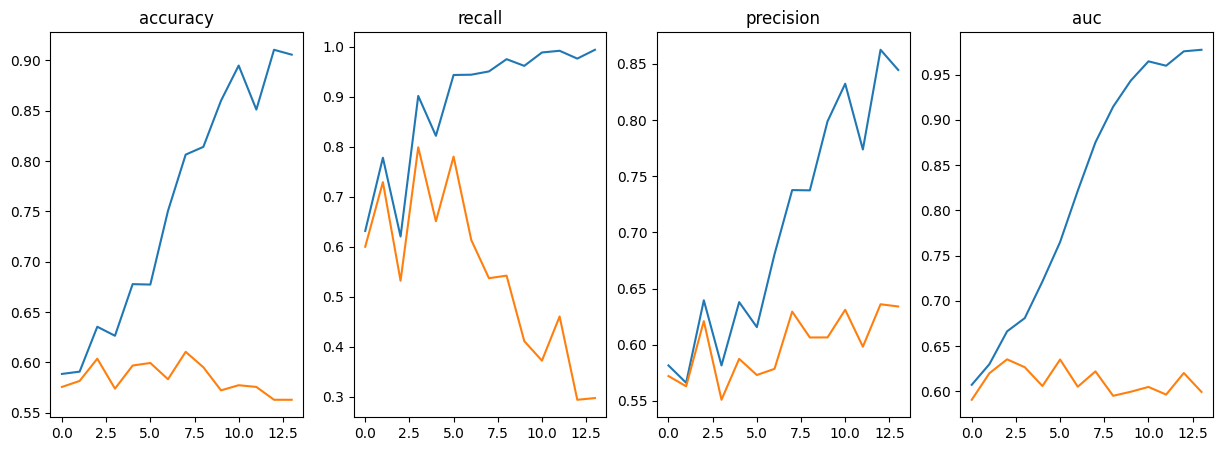

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [14] [  0/141]  eta: 0:17:15  lr: 0.000016  loss: 0.2279  time: 7.3459  data: 6.3268  max mem: 28887
Train Epoch: [14] [ 20/141]  eta: 0:03:22  lr: 0.000016  loss: 0.1680  time: 1.3926  data: 0.4799  max mem: 28887
Train Epoch: [14] [ 40/141]  eta: 0:02:31  lr: 0.000016  loss: 0.1849  time: 1.3185  data: 0.4080  max mem: 28887
Train Epoch: [14] [ 60/141]  eta: 0:01:56  lr: 0.000016  loss: 0.2363  time: 1.3088  data: 0.1283  max mem: 28887
Train Epoch: [14] [ 80/141]  eta: 0:01:25  lr: 0.000016  loss: 0.1252  time: 1.2730  data: 0.3617  max mem: 28887
Train Epoch: [14] [100/141]  eta: 0:00:55  lr: 0.000017  loss: 0.2022  time: 1.1810  data: 0.2510  max mem: 28887
Train Epoch: [14] [120/141]  eta: 0:00:28  lr: 0.000017  loss: 0.1089  time: 1.3631  data: 0.4352  max mem: 28887
Train Epoch: [14] [140/141]  eta: 0:00:01  lr: 0.000017  loss: 0.1693  time: 1.2714  data: 0.1908  max mem: 28887
Train Epoch: [14] Total time: 0:03:09 (1.3442 s / it)
start eval on train dataset ------

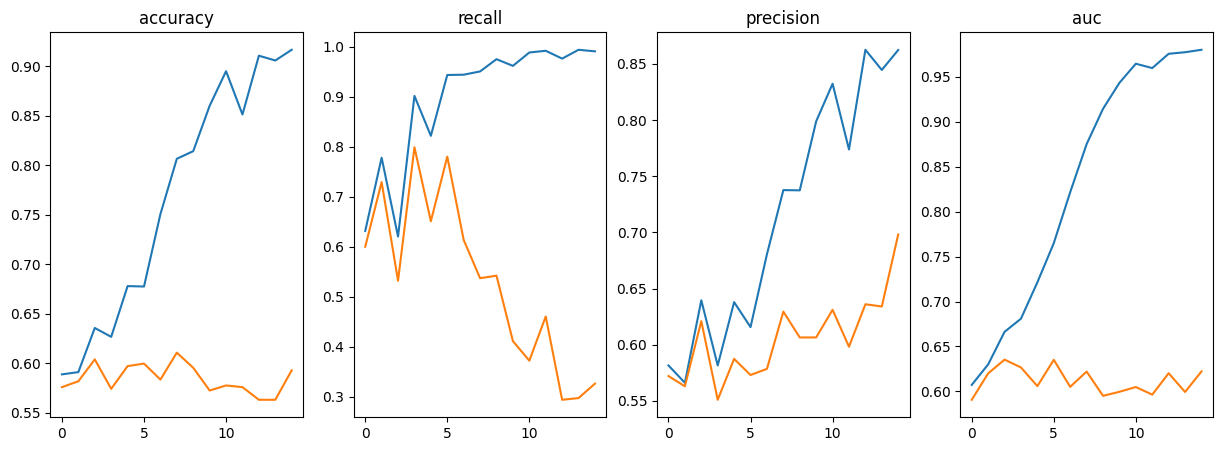

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [15] [  0/141]  eta: 0:18:31  lr: 0.000017  loss: 0.1671  time: 7.8827  data: 6.7464  max mem: 28887
Train Epoch: [15] [ 20/141]  eta: 0:03:14  lr: 0.000017  loss: 0.0972  time: 1.2949  data: 0.3955  max mem: 28887
Train Epoch: [15] [ 40/141]  eta: 0:02:35  lr: 0.000017  loss: 0.1138  time: 1.4593  data: 0.1969  max mem: 28887
Train Epoch: [15] [ 60/141]  eta: 0:01:53  lr: 0.000017  loss: 0.3053  time: 1.1342  data: 0.2575  max mem: 28887
Train Epoch: [15] [ 80/141]  eta: 0:01:24  lr: 0.000018  loss: 0.1673  time: 1.3352  data: 0.4287  max mem: 28887
Train Epoch: [15] [100/141]  eta: 0:00:56  lr: 0.000018  loss: 0.1727  time: 1.3088  data: 0.4187  max mem: 28887
Train Epoch: [15] [120/141]  eta: 0:00:29  lr: 0.000018  loss: 0.2137  time: 1.4954  data: 0.3717  max mem: 28887
Train Epoch: [15] [140/141]  eta: 0:00:01  lr: 0.000018  loss: 0.3878  time: 1.1098  data: 0.2234  max mem: 28887
Train Epoch: [15] Total time: 0:03:10 (1.3521 s / it)
start eval on train dataset ------

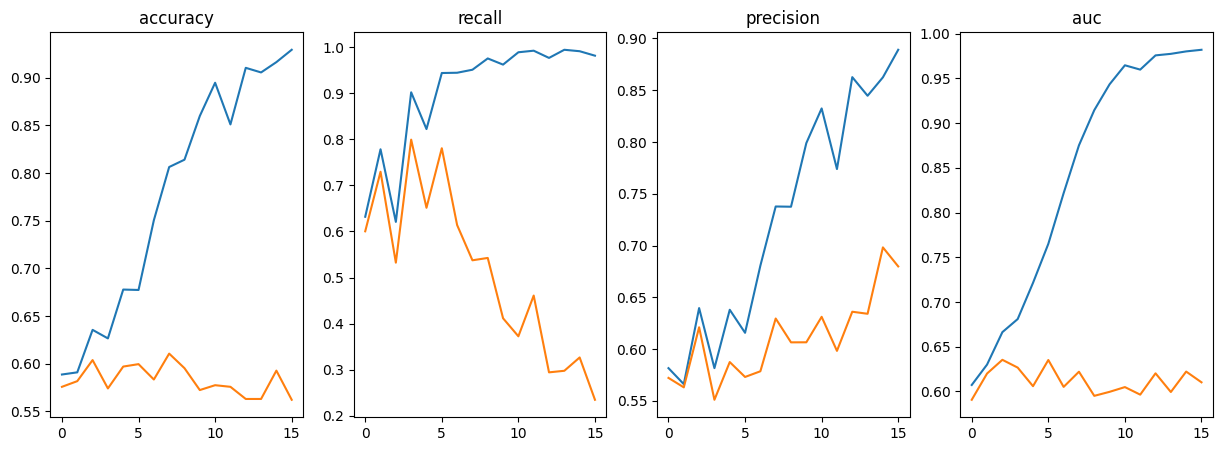

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [16] [  0/141]  eta: 0:19:09  lr: 0.000018  loss: 0.0947  time: 8.1558  data: 7.0968  max mem: 28887
Train Epoch: [16] [ 20/141]  eta: 0:03:48  lr: 0.000018  loss: 0.1141  time: 1.5780  data: 0.4157  max mem: 28887
Train Epoch: [16] [ 40/141]  eta: 0:02:34  lr: 0.000018  loss: 0.2397  time: 1.1424  data: 0.2307  max mem: 28887
Train Epoch: [16] [ 60/141]  eta: 0:01:57  lr: 0.000019  loss: 0.2111  time: 1.2883  data: 0.3809  max mem: 28887
Train Epoch: [16] [ 80/141]  eta: 0:01:26  lr: 0.000019  loss: 0.0884  time: 1.3485  data: 0.4018  max mem: 28887
Train Epoch: [16] [100/141]  eta: 0:00:57  lr: 0.000019  loss: 0.0915  time: 1.3169  data: 0.1800  max mem: 28887
Train Epoch: [16] [120/141]  eta: 0:00:28  lr: 0.000019  loss: 0.2614  time: 1.1240  data: 0.1959  max mem: 28887
Train Epoch: [16] [140/141]  eta: 0:00:01  lr: 0.000019  loss: 0.0891  time: 1.2156  data: 0.3003  max mem: 28887
Train Epoch: [16] Total time: 0:03:08 (1.3365 s / it)
start eval on train dataset ------

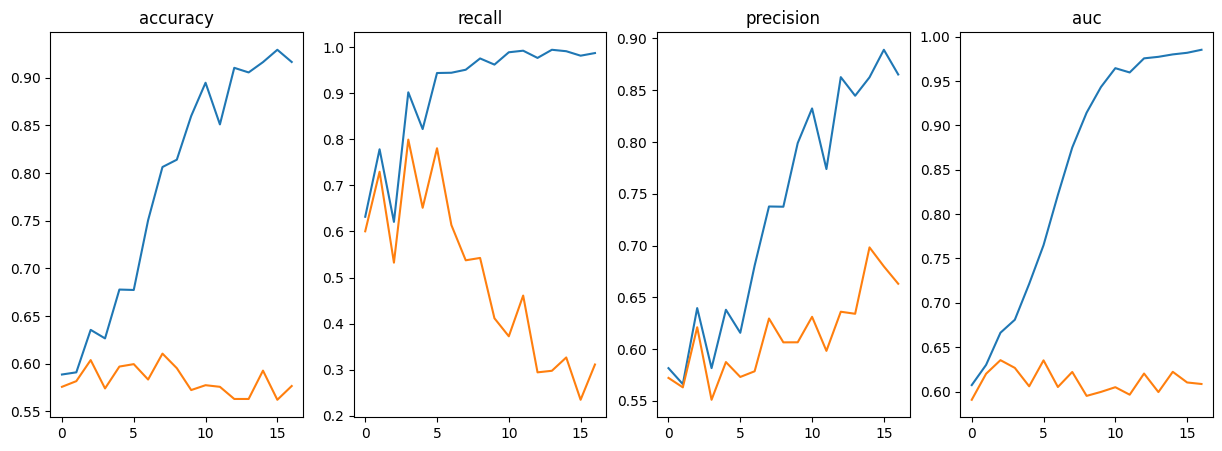

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [17] [  0/141]  eta: 0:16:52  lr: 0.000019  loss: 0.2290  time: 7.1822  data: 6.1261  max mem: 28887
Train Epoch: [17] [ 20/141]  eta: 0:03:08  lr: 0.000019  loss: 0.0657  time: 1.2745  data: 0.3678  max mem: 28887
Train Epoch: [17] [ 40/141]  eta: 0:02:22  lr: 0.000020  loss: 0.0540  time: 1.2499  data: 0.3380  max mem: 28887
Train Epoch: [17] [ 60/141]  eta: 0:01:51  lr: 0.000020  loss: 0.1104  time: 1.2968  data: 0.3749  max mem: 28887
Train Epoch: [17] [ 80/141]  eta: 0:01:24  lr: 0.000020  loss: 0.1322  time: 1.4629  data: 0.2876  max mem: 28887
Train Epoch: [17] [100/141]  eta: 0:00:55  lr: 0.000020  loss: 0.0780  time: 1.1344  data: 0.2044  max mem: 28887
Train Epoch: [17] [120/141]  eta: 0:00:27  lr: 0.000000  loss: 0.1199  time: 1.2332  data: 0.3234  max mem: 28887
Train Epoch: [17] [140/141]  eta: 0:00:01  lr: 0.000000  loss: 0.2869  time: 1.1769  data: 0.2611  max mem: 28887
Train Epoch: [17] Total time: 0:03:03 (1.3033 s / it)
start eval on train dataset ------

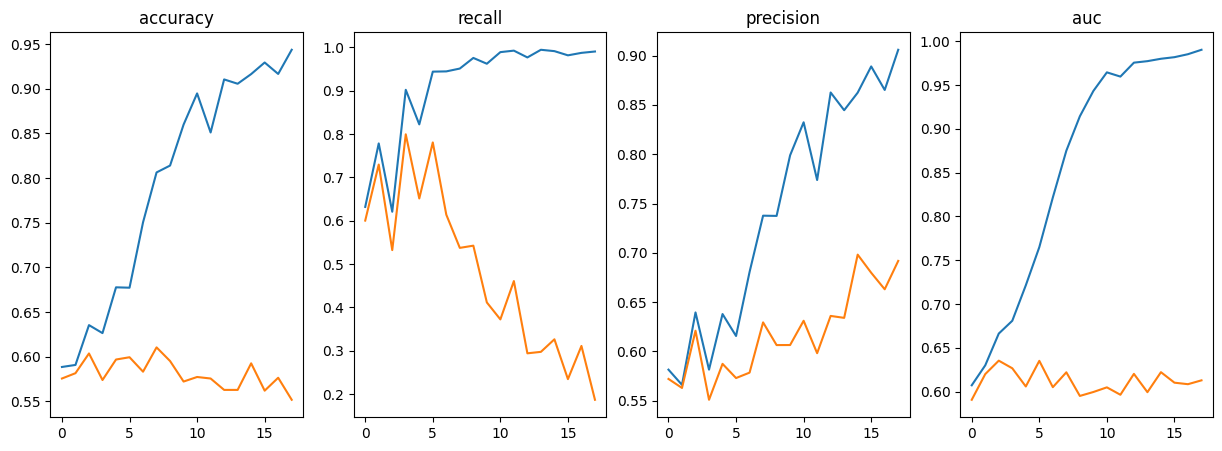

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [18] [  0/141]  eta: 0:18:31  lr: 0.000000  loss: 0.1390  time: 7.8831  data: 6.8329  max mem: 28887
Train Epoch: [18] [ 20/141]  eta: 0:03:16  lr: 0.000000  loss: 0.1572  time: 1.3097  data: 0.4026  max mem: 28887
Train Epoch: [18] [ 40/141]  eta: 0:02:22  lr: 0.000000  loss: 0.2287  time: 1.1830  data: 0.2690  max mem: 28887
Train Epoch: [18] [ 60/141]  eta: 0:01:50  lr: 0.000000  loss: 0.1322  time: 1.2765  data: 0.3721  max mem: 28887
Train Epoch: [18] [ 80/141]  eta: 0:01:22  lr: 0.000000  loss: 0.0721  time: 1.3190  data: 0.1519  max mem: 28887
Train Epoch: [18] [100/141]  eta: 0:00:55  lr: 0.000000  loss: 0.2329  time: 1.2964  data: 0.3693  max mem: 28887
Train Epoch: [18] [120/141]  eta: 0:00:27  lr: 0.000000  loss: 0.1201  time: 1.1947  data: 0.2843  max mem: 28887
Train Epoch: [18] [140/141]  eta: 0:00:01  lr: 0.000000  loss: 0.0438  time: 1.1400  data: 0.2386  max mem: 28887
Train Epoch: [18] Total time: 0:03:02 (1.2928 s / it)
start eval on train dataset ------

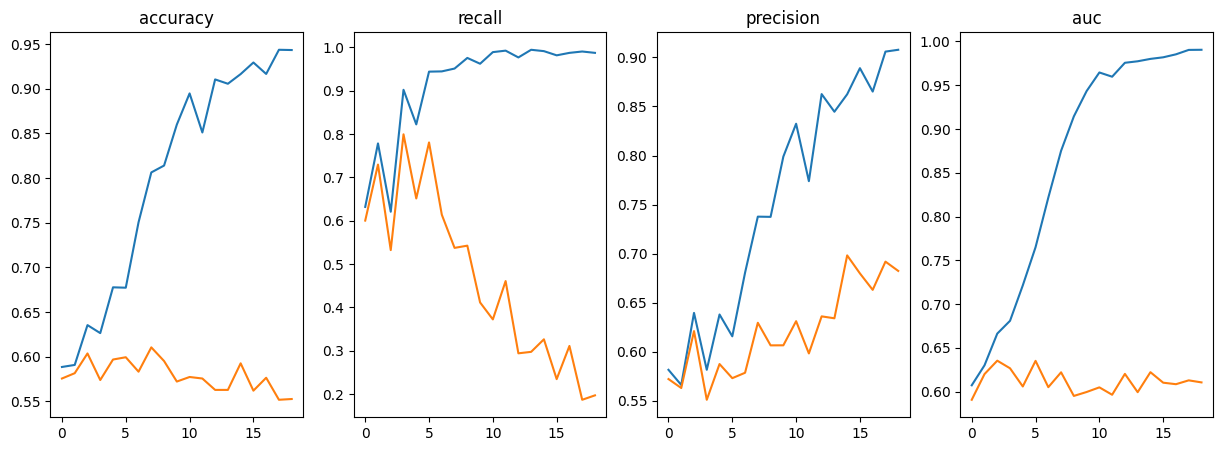

/home/kh3074/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Epoch: [19] [  0/141]  eta: 0:18:17  lr: 0.000000  loss: 0.0703  time: 7.7823  data: 6.7076  max mem: 28887
Train Epoch: [19] [ 20/141]  eta: 0:03:08  lr: 0.000000  loss: 0.2410  time: 1.2431  data: 0.3422  max mem: 28887
Train Epoch: [19] [ 40/141]  eta: 0:02:26  lr: 0.000000  loss: 0.2311  time: 1.3361  data: 0.3901  max mem: 28887
Train Epoch: [19] [ 60/141]  eta: 0:01:51  lr: 0.000000  loss: 0.1375  time: 1.2460  data: 0.0726  max mem: 28887
Train Epoch: [19] [ 80/141]  eta: 0:01:22  lr: 0.000000  loss: 0.0630  time: 1.2536  data: 0.3458  max mem: 28887
Train Epoch: [19] [100/141]  eta: 0:00:55  lr: 0.000000  loss: 0.1236  time: 1.3118  data: 0.3888  max mem: 28887
Train Epoch: [19] [120/141]  eta: 0:00:28  lr: 0.000000  loss: 0.0992  time: 1.3194  data: 0.3744  max mem: 28887
Train Epoch: [19] [140/141]  eta: 0:00:01  lr: 0.000000  loss: 0.2092  time: 1.3084  data: 0.2322  max mem: 28887
Train Epoch: [19] Total time: 0:03:08 (1.3345 s / it)
start eval on train dataset ------

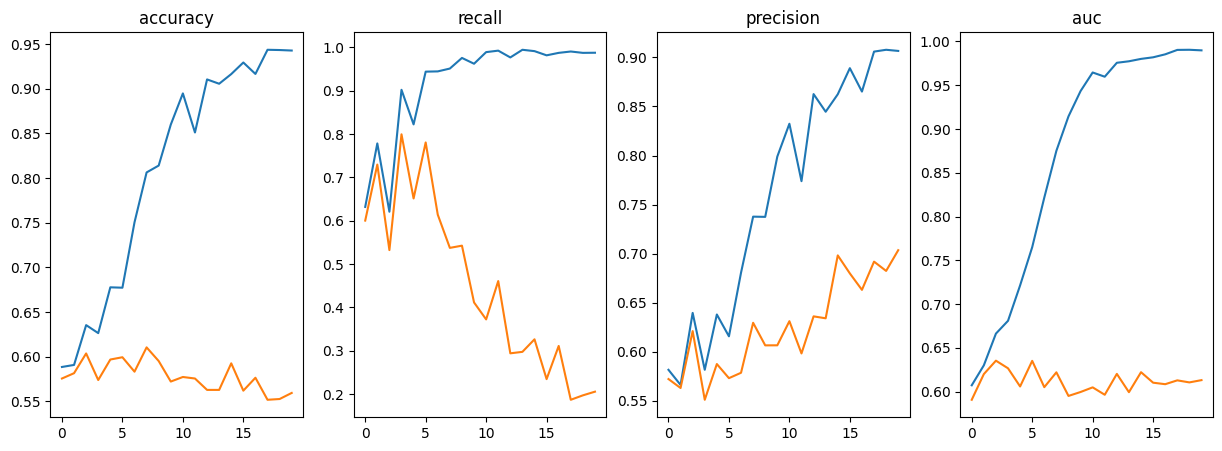

In [11]:
# trainging loop for cls head

# for each epoch: 
# 1: create a downsampled training data loader with random seed.
# 2: model.train:   train one epoch
# 3: evaluate model.eval():  (1): eval on balanced training dataset, 
                            #(2): eval on balanced val() dataset, 
                            #(3):eval on full val dataset ❌
        
# 4: model.save: preserve the model with highest eval performance



metric_logger = utils.MetricLogger(delimiter="  ")
metric_logger.add_meter('lr', utils.SmoothedValue(window_size=50, fmt='{value:.6f}'))
metric_logger.add_meter('loss', utils.SmoothedValue(window_size=50, fmt='{value:.4f}'))
 
print_freq = 20
train_accuracys = []
train_recalls = []
train_precisions = []
train_aucs = []
train_auc_precisions = []
train_auc_recalls = []
val_accuracys = []
val_recalls = []
val_precisions = []
val_aucs = []
val_auc_precisions = []
val_auc_recalls = []

top_models = []
# dirs
#os.makedirs('/mnt/swordfish-pool2/kh3074/train_cls_head_first/evaluate_results')
#os.makedirs('/mnt/swordfish-pool2/kh3074/train_cls_head_first/save_models')
#os.makedirs('/mnt/swordfish-pool2/kh3074/train_cls_head_first/trained_cls_head_model')
model_save_dir = '/mnt/swordfish-pool2/kh3074/train_cls_head_first/save_models'
log_save_dir = '/mnt/swordfish-pool2/kh3074/train_cls_head_first/evaluate_results'


print('Start training!!')
for epoch in range(num_epoch):
    # start new epoch of training
    my_nvlr_model.train()
    for param in my_nvlr_model.parameters():
        param.requires_grad = True
    for param in my_nvlr_model.module.cls_head.parameters():
        param.requires_grad = True
    
    train_data_loader = create_down_sample_dataloader(train_csv, epoch, train_batch_size, 
                              train_transform,evaluation = False) # use epoch as random seed
    header = 'Train Epoch: [{}]'.format(epoch) 
    for i, (image0, image1, text, targets) in enumerate(metric_logger.log_every(train_data_loader, print_freq, header)):
        images = torch.cat([image0, image1], dim=0)
        images, targets = images.to(device), targets.to(device)   

        text_inputs = tokenizer(text, padding='longest', return_tensors="pt").to(device)  

        loss = my_nvlr_model(images, text_inputs.input_ids, text_inputs.attention_mask, targets=targets, train=True)
        loss = loss.mean() # aggregate loss from different GPUs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(loss=loss.item())
        
    # start evaluation
    my_nvlr_model.eval() 
    # create eval_Dataloader with fix seed for val dataset
    print('start eval on train dataset ---------------------------------------------')
    train_eval_data_loader = create_down_sample_dataloader(train_csv, 2333, eval_batch_size, 
                              val_transform,evaluation = True)
    eval_train_df = eval_on_dataset(my_nvlr_model,train_eval_data_loader,device,tokenizer)
    train_recall, train_precision, train_accuracy, train_pr_auc, train_precision_auc, train_recall_auc = calculate_matrix(eval_train_df)
    
    train_accuracys.append(train_accuracy)
    train_recalls.append(train_recall)
    train_precisions.append(train_precision)
    train_aucs.append(train_pr_auc)
    train_auc_precisions.append(train_precision_auc)
    train_auc_recalls.append(train_recall_auc)
    
    
    print('start eval on validation dataset ---------------------------------------------')
    val_data_loader = create_down_sample_dataloader(val_csv, 2333, eval_batch_size, 
                              val_transform,evaluation = True) # fix seed 2333
    eval_val_df = eval_on_dataset(my_nvlr_model,val_data_loader,device,tokenizer)
    val_recall, val_precision, val_accuracy, val_pr_auc, val_precision_auc, val_recall_auc = calculate_matrix(eval_val_df)
    
    val_accuracys.append(val_accuracy)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)
    val_aucs.append(val_pr_auc)
    val_auc_precisions.append(val_precision_auc)
    val_auc_recalls.append(val_recall_auc)
    
    
    # if auc of val dataset is the top 3, then save the model
    if len(top_models) < 3:
        top_models.append((f'model_tuned_epoch_{epoch}', val_pr_auc))
    else:
        top_models.append((f'model_tuned_epoch_{epoch}', val_pr_auc))
        top_models.sort(key=lambda x: x[1], reverse=True)
        
        if os.path.exists(os.path.join(model_save_dir,top_models[-1][0])):
            os.remove(os.path.join(model_save_dir,top_models[-1][0]))
        top_models.pop(3)
        for i in range(3):
            if os.path.exists(os.path.join(model_save_dir,top_models[i][0])):
                pass
            else:
                torch.save(my_nvlr_model.state_dict(), os.path.join(model_save_dir,top_models[i][0]))
    torch.cuda.empty_cache()

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger.global_avg())     
    log.append({k: "{:.5f}".format(meter.global_avg) for k, meter in metric_logger.meters.items()})
    
    #vis
    train_result_df = pd.DataFrame({'train_accuracys':train_accuracys,
                         'train_recalls':train_recalls ,
                         'train_precisions':train_precisions ,
                         'train_aucs':train_aucs ,
                         'train_auc_precisions':train_auc_precisions ,
                         'train_auc_recalls':train_auc_recalls ,
                         'val_accuracys':val_accuracys ,
                         'val_recalls':val_recalls ,
                         'val_precisions':val_precisions ,
                         'val_aucs':val_aucs ,
                         'val_auc_precisions':val_auc_precisions ,
                         'val_auc_recalls':val_auc_recalls })
    
    fig, ax = plt.subplots(1,4, figsize = (15,5))
    epoch_idx = range(len(train_result_df))

    ax[0].plot(epoch_idx,train_result_df.train_accuracys)
    ax[0].set_title('accuracy')

    ax[1].plot(epoch_idx,train_result_df.train_recalls)
    ax[1].set_title('recall')

    ax[2].plot(epoch_idx,train_result_df.train_precisions)
    ax[2].set_title('precision')

    ax[3].plot(epoch_idx,train_result_df.train_aucs)
    ax[3].set_title('auc')


    ax[0].plot(epoch_idx,train_result_df.val_accuracys)
    ax[1].plot(epoch_idx,train_result_df.val_recalls)
    ax[2].plot(epoch_idx,train_result_df.val_precisions)
    ax[3].plot(epoch_idx,train_result_df.val_aucs)
    plt.show()
    
    train_result_df.to_csv(os.path.join(log_save_dir,'train_finetune'))

In [12]:
# 28开始的时候计时

In [13]:
train_result_df = pd.DataFrame({'train_accuracys':train_accuracys,
                         'train_recalls':train_recalls ,
                         'train_precisions':train_precisions ,
                         'train_aucs':train_aucs ,
                         'train_auc_precisions':train_auc_precisions ,
                         'train_auc_recalls':train_auc_recalls ,
                         'val_accuracys':val_accuracys ,
                         'val_recalls':val_recalls ,
                         'val_precisions':val_precisions ,
                         'val_aucs':val_aucs ,
                         'val_auc_precisions':val_auc_precisions ,
                         'val_auc_recalls':val_auc_recalls })

In [14]:
train_result_df.to_csv(os.path.join(log_save_dir,'train_finetune'))

In [15]:
top_models# higher

[('model_tuned_epoch_2', 0.6353683415133307),
 ('model_tuned_epoch_5', 0.6351596086549072),
 ('model_tuned_epoch_3', 0.6266662795187583)]

In [16]:
# plot visualizations

# load result file
train_result_df = pd.read_csv(os.path.join(log_save_dir,'train_finetune'))

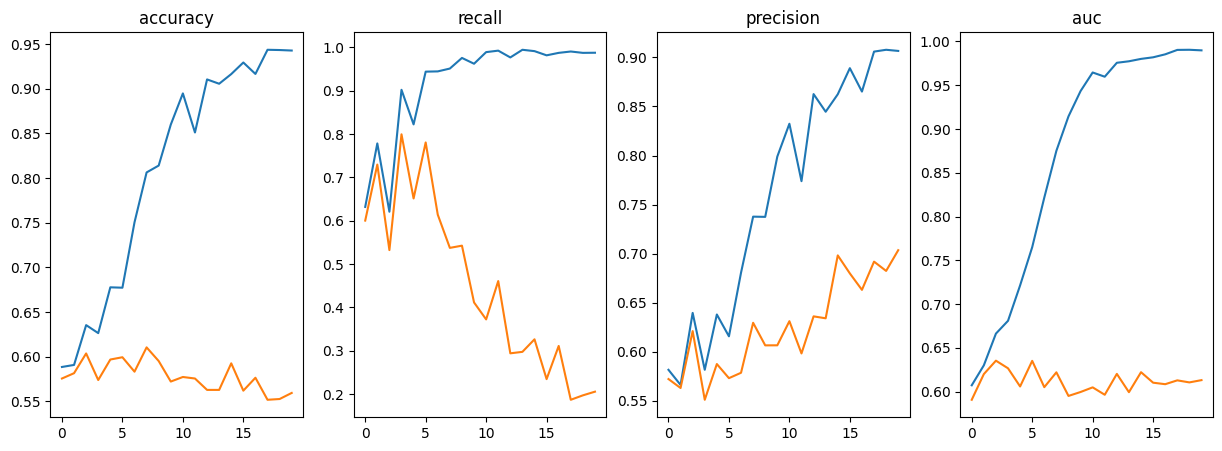

In [17]:
fig, ax = plt.subplots(1,4, figsize = (15,5))
epoch_idx = range(len(train_result_df))

ax[0].plot(epoch_idx,train_result_df.train_accuracys)
ax[0].set_title('accuracy')

ax[1].plot(epoch_idx,train_result_df.train_recalls)
ax[1].set_title('recall')

ax[2].plot(epoch_idx,train_result_df.train_precisions)
ax[2].set_title('precision')

ax[3].plot(epoch_idx,train_result_df.train_aucs)
ax[3].set_title('auc')


ax[0].plot(epoch_idx,train_result_df.val_accuracys)
ax[1].plot(epoch_idx,train_result_df.val_recalls)
ax[2].plot(epoch_idx,train_result_df.val_precisions)
ax[3].plot(epoch_idx,train_result_df.val_aucs)

# trainging loop for finetuning the whole model

# for each epoch: 
# 1: create a downsampled training data loader with random seed.
# 2: model.train:   train one epoch
# 3: evaluate model.eval():  (1): eval on balanced training dataset, 
                            #(2): eval on balanced val() dataset, 
                            #(3):eval on full val dataset ❌
        
# 4: model.save: preserve the model with highest eval performance



metric_logger = utils.MetricLogger(delimiter="  ")
metric_logger.add_meter('lr', utils.SmoothedValue(window_size=50, fmt='{value:.6f}'))
metric_logger.add_meter('loss', utils.SmoothedValue(window_size=50, fmt='{value:.4f}'))
 
print_freq = 50
train_accuracys = []
train_recalls = []
train_precisions = []
train_aucs = []
train_auc_precisions = []
train_auc_recalls = []
val_accuracys = []
val_recalls = []
val_precisions = []
val_aucs = []
val_auc_precisions = []
val_auc_recalls = []

top_models = []
# dirs
# '/mnt/swordfish-pool2/kh3074/random_crop'
# '/mnt/swordfish-pool2/kh3074/random_crop/saved_models'
# '/mnt/swordfish-pool2/kh3074/random_crop/evaluate_results'

# '/mnt/swordfish-pool2/kh3074/zoomed_random_crop'
# '/mnt/swordfish-pool2/kh3074/zoomed_random_crop/saved_models'
# '/mnt/swordfish-pool2/kh3074/zoomed_random_crop/evaluate_results'
model_save_dir = '/mnt/swordfish-pool2/kh3074/test_bug/save_models'
log_save_dir = '/mnt/swordfish-pool2/kh3074/test_bug/evaluate_results'


print('Start training!!')
for epoch in range(num_epoch):
    # start new epoch of training
    my_nvlr_model.train()
    
    train_data_loader = create_down_sample_dataloader(train_csv, epoch, train_batch_size, 
                              train_transform,evaluation = False) # use epoch as random seed
    header = 'Train Epoch: [{}]'.format(epoch) 
    for i, (image0, image1, text, targets) in enumerate(metric_logger.log_every(train_transform_zoom_corp, print_freq, header)):
        images = torch.cat([image0, image1], dim=0)
        images, targets = images.to(device), targets.to(device)   

        text_inputs = tokenizer(text, padding='longest', return_tensors="pt").to(device)  

        loss = my_nvlr_model(images, text_inputs.input_ids, text_inputs.attention_mask, targets=targets, train=True)
        loss = loss.mean() # aggregate loss from different GPUs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(loss=loss.item())
        
    # start evaluation
    my_nvlr_model.eval() 
    # create eval_Dataloader with fix seed for val dataset
    print('start eval on train dataset ---------------------------------------------')
    train_eval_data_loader = create_down_sample_dataloader(train_csv, 2333, eval_batch_size, 
                              val_transform,evaluation = True)
    eval_train_df = eval_on_dataset(my_nvlr_model,train_eval_data_loader,device,tokenizer)
    train_recall, train_precision, train_accuracy, train_pr_auc, train_precision_auc, train_recall_auc = calculate_matrix(eval_train_df)
    
    train_accuracys.append(train_accuracy)
    train_recalls.append(train_recall)
    train_precisions.append(train_precision)
    train_aucs.append(train_pr_auc)
    train_auc_precisions.append(train_precision_auc)
    train_auc_recalls.append(train_recall_auc)
    
    
    print('start eval on validation dataset ---------------------------------------------')
    val_data_loader = create_down_sample_dataloader(val_csv, 2333, eval_batch_size, 
                              val_transform,evaluation = True) # fix seed 2333
    eval_val_df = eval_on_dataset(my_nvlr_model,val_data_loader,device,tokenizer)
    val_recall, val_precision, val_accuracy, val_pr_auc, val_precision_auc, val_recall_auc = calculate_matrix(eval_val_df)
    
    val_accuracys.append(val_accuracy)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)
    val_aucs.append(val_pr_auc)
    val_auc_precisions.append(val_precision_auc)
    val_auc_recalls.append(val_recall_auc)
    
    
    # if auc of val dataset is the top 3, then save the model
    if len(top_models) < 3:
        top_models.append((f'model_tuned_epoch_{epoch}', val_pr_auc))
    else:
        top_models.append((f'model_tuned_epoch_{epoch}', val_pr_auc))
        top_models.sort(key=lambda x: x[1], reverse=True)
        
        if os.path.exists(os.path.join(model_save_dir,top_models[-1][0])):
            os.remove(os.path.join(model_save_dir,top_models[-1][0]))
        top_models.pop(3)
        for i in range(3):
            if os.path.exists(os.path.join(model_save_dir,top_models[i][0])):
                pass
            else:
                torch.save(my_nvlr_model.state_dict(), os.path.join(model_save_dir,top_models[i][0]))
    torch.cuda.empty_cache()

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger.global_avg())     
    log.append({k: "{:.5f}".format(meter.global_avg) for k, meter in metric_logger.meters.items()})